# Predictive maintenance of turbofans
In this notebook I show how to develop several models to predict the Remaining Useful Life (RUL) of turbofans.

In [70]:
import math
import warnings
from itertools import product

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import stats, optimize
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings('ignore', category = RuntimeWarning)

## EDA

The turbofan dataset consists of four datasets from which we will <u>only use the first</u>.</br> 
Each dataset consists of three files:
- A <u>train dataset</u>. This dataset consists of operating data on 100 new turbofan engines. The data consists multiple rows of flight data for each engine. One row for each flight (time step) until engine failure: so the last row for each enigine is the last flight before failure.
- A <u>test dataset</u>. This dataset consists of similar operating data on 100 different new turbofan engines. Here, however, data rows are NOT given until failure, but until some arbitrary point in time.
- A list of <u>target values</u>. This list consists of a single number for each of the 100 test dataset engines. This is the number of time steps remaining until failure for each of the test dataset engines.

In our notebooks, the terms 'engine' and 'machine' are used interchangeably.

In [2]:
#Loading the data, setting some variables and assign IDs

operator_columns = ['Operational setting 1','Operational setting 2','Operational setting 3']
sensor_columns = ['T2','T24','T30','T50','P2','P15','P30','Nf','Nc','epr','Ps30','phi',
                  'NRf','NRc','BPR','farB','htBleed','NF_dmd','PCNfR_dmd','W31','W32']
index_columns = ['Machine id','Time unit']
data_columns = index_columns + operator_columns + sensor_columns
file_columns = data_columns + ['1','2'] ## these absorb trailing spaces in the input files

train = pd.read_csv("data/train_FD001.txt", sep=' ', names=file_columns, index_col=index_columns, usecols=data_columns )
test = pd.read_csv("data/test_FD001.txt", sep=' ', names=file_columns, index_col=index_columns, usecols=data_columns )
target = pd.read_csv("data/RUL_FD001.txt", sep=' ', names=['RUL','dummy'], usecols=['RUL'])

train_machine_ids = range(1, 101)
test_machine_ids = range(101, 201)

test = test.reset_index('Machine id')
test['Machine id'] += 100
test = test.set_index('Machine id', drop = True, append = True).swaplevel()
target['Machine id'] = test_machine_ids
target = target.set_index('Machine id')

In [3]:
train

Operational setting 1  Operational setting 2  \
Machine id Time unit                                                 
1          1                        -0.0007                -0.0004   
           2                         0.0019                -0.0003   
           3                        -0.0043                 0.0003   
           4                         0.0007                 0.0000   
           5                        -0.0019                -0.0002   
...                                     ...                    ...   
100        196                      -0.0004                -0.0003   
           197                      -0.0016                -0.0005   
           198                       0.0004                 0.0000   
           199                      -0.0011                 0.0003   
           200                      -0.0032                -0.0005   

                      Operational setting 3      T2     T24      T30      T50  \
Machine id Time unit                                                            
1          1                          100.0  518.67  641.82  1589.70  1400.60   
           2                          100.0  518.67  642.15  1591.82  1403.14   
           3                          100.0  518.67  642.35  1587.99  1404.20   
           4                          100.0  518.67  642.35  1582.79  1401.87   
           5                          100.0  518.67  642.37  1582.85  1406.22   
...                                     ...     ...     ...      ...      ...   
100        196                        100.0  518.67  643.49  1597.98  1428.63   
           197                        100.0  518.67  643.54  1604.50  1433.58   
           198                        100.0  518.67  643.42  1602.46  1428.18   
           199                        100.0  518.67  643.23  1605.26  1426.53   
           200                        100.0  518.67  643.85  1600.38  1432.14   

                         P2    P15     P30  ...     phi      NRf      NRc  \
Machine id Time unit                        ...                             
1          1          14.62  21.61  554.36  ...  521.66  2388.02  8138.62   
           2          14.62  21.61  553.75  ...  522.28  2388.07  8131.49   
           3          14.62  21.61  554.26  ...  522.42  2388.03  8133.23   
           4          14.62  21.61  554.45  ...  522.86  2388.08  8133.83   
           5          14.62  21.61  554.00  ...  522.19  2388.04  8133.80   
...                     ...    ...     ...  ...     ...      ...      ...   
100        196        14.62  21.61  551.43  ...  519.49  2388.26  8137.60   
           197        14.62  21.61  550.86  ...  519.68  2388.22  8136.50   
           198        14.62  21.61  550.94  ...  520.01  2388.24  8141.05   
           199        14.62  21.61  550.68  ...  519.67  2388.23  8139.29   
           200        14.62  21.61  550.79  ...  519.30  2388.26  8137.33   

                         BPR  farB  htBleed  NF_dmd  PCNfR_dmd    W31      W32  
Machine id Time unit                                                            
1          1          8.4195  0.03      392    2388      100.0  39.06  23.4190  
           2          8.4318  0.03      392    2388      100.0  39.00  23.4236  
           3          8.4178  0.03      390    2388      100.0  38.95  23.3442  
           4          8.3682  0.03      392    2388      100.0  38.88  23.3739  
           5          8.4294  0.03      393    2388      100.0  38.90  23.4044  
...                      ...   ...      ...     ...        ...    ...      ...  
100        196        8.4956  0.03      397    2388      100.0  38.49  22.9735  
           197        8.5139  0.03      395    2388      100.0  38.30  23.1594  
           198        8.5646  0.03      398    2388      100.0  38.44  22.9333  
           199        8.5389  0.03      395    2388      100.0  38.29  23.0640  
           200        8.5036  0.03      396    2388      100.0  38.37  23.0522  

[

In [4]:
train.loc[1]

Operational setting 1  Operational setting 2  \
Time unit                                                 
1                        -0.0007                -0.0004   
2                         0.0019                -0.0003   
3                        -0.0043                 0.0003   
4                         0.0007                 0.0000   
5                        -0.0019                -0.0002   
...                          ...                    ...   
188                      -0.0067                 0.0003   
189                      -0.0006                 0.0002   
190                      -0.0027                 0.0001   
191                      -0.0000                -0.0004   
192                       0.0009                -0.0000   

           Operational setting 3      T2     T24      T30      T50     P2  \
Time unit                                                                   
1                          100.0  518.67  641.82  1589.70  1400.60  14.62   
2                          100.0  518.67  642.15  1591.82  1403.14  14.62   
3                          100.0  518.67  642.35  1587.99  1404.20  14.62   
4                          100.0  518.67  642.35  1582.79  1401.87  14.62   
5                          100.0  518.67  642.37  1582.85  1406.22  14.62   
...                          ...     ...     ...      ...      ...    ...   
188                        100.0  518.67  643.75  1602.38  1422.78  14.62   
189                        100.0  518.67  644.18  1596.17  1428.01  14.62   
190                        100.0  518.67  643.64  1599.22  1425.95  14.62   
191                        100.0  518.67  643.34  1602.36  1425.77  14.62   
192                        100.0  518.67  643.54  1601.41  1427.20  14.62   

             P15     P30  ...     phi      NRf      NRc     BPR  farB  \
Time unit                 ...                                           
1          21.61  554.36  ...  521.66  2388.02  8138.62  8.4195  0.03   
2          21.61  553.75  ...  522.28  2388.07  8131.49  8.4318  0.03   
3          21.61  554.26  ...  522.42  2388.03  8133.23  8.4178  0.03   
4          21.61  554.45  ...  522.86  2388.08  8133.83  8.3682  0.03   
5          21.61  554.00  ...  522.19  2388.04  8133.80  8.4294  0.03   
...          ...     ...  ...     ...      ...      ...     ...   ...   
188        21.61  551.94  ...  519.79  2388.23  8117.69  8.5207  0.03   
189        21.61  550.70  ...  519.58  2388.33  8117.51  8.5183  0.03   
190        21.61  551.29  ...  520.04  2388.35  8112.58  8.5223  0.03   
191        21.61  550.92  ...  519.57  2388.30  8114.61  8.5174  0.03   
192        21.61  551.25  ...  520.08  2388.32  8110.93  8.5113  0.03   

           htBleed  NF_dmd  PCNfR_dmd    W31      W32  
Time unit                                              
1              392    2388      100.0  39.06  23.4190  
2              392    2388      100.0  39.00  23.4236  
3              390    2388      100.0  38.95  23.3442  
4              392    2388      100.0  38.88  23.3739  
5              393    2388      100.0  38.90  23.4044  
...            ...     ...        ...    ...      ...  
188            396    2388      100.0  38.51  22.9588  
189            395    2388      100.0  38.48  23.1127  
190            398    2388      100.0  38.49  23.0675  
191            394    2388      100.0  38.45  23.1295  
192            396    2388      100.0  38.48  22.9649  

[192 rows x 24 columns]

In [5]:
test

Operational setting 1  Operational setting 2  \
Machine id Time unit                                                 
101        1                         0.0023                 0.0003   
           2                        -0.0027                -0.0003   
           3                         0.0003                 0.0001   
           4                         0.0042                 0.0000   
           5                         0.0014                 0.0000   
...                                     ...                    ...   
200        194                       0.0049                 0.0000   
           195                      -0.0011                -0.0001   
           196                      -0.0006                -0.0003   
           197                      -0.0038                 0.0001   
           198                       0.0013                 0.0003   

                      Operational setting 3      T2     T24      T30      T50  \
Machine id Time unit                                                            
101        1                          100.0  518.67  643.02  1585.29  1398.21   
           2                          100.0  518.67  641.71  1588.45  1395.42   
           3                          100.0  518.67  642.46  1586.94  1401.34   
           4                          100.0  518.67  642.44  1584.12  1406.42   
           5                          100.0  518.67  642.51  1587.19  1401.92   
...                                     ...     ...     ...      ...      ...   
200        194                        100.0  518.67  643.24  1599.45  1415.79   
           195                        100.0  518.67  643.22  1595.69  1422.05   
           196                        100.0  518.67  643.44  1593.15  1406.82   
           197                        100.0  518.67  643.26  1594.99  1419.36   
           198                        100.0  518.67  642.95  1601.62  1424.99   

                         P2    P15     P30  ...     phi      NRf      NRc  \
Machine id Time unit                        ...                             
101        1          14.62  21.61  553.90  ...  521.72  2388.03  8125.55   
           2          14.62  21.61  554.85  ...  522.16  2388.06  8139.62   
           3          14.62  21.61  554.11  ...  521.97  2388.03  8130.10   
           4          14.62  21.61  554.07  ...  521.38  2388.05  8132.90   
           5          14.62  21.61  554.16  ...  522.15  2388.03  8129.54   
...                     ...    ...     ...  ...     ...      ...      ...   
200        194        14.62  21.61  553.41  ...  520.69  2388.00  8213.28   
           195        14.62  21.61  553.22  ...  521.05  2388.09  8210.85   
           196        14.62  21.61  553.04  ...  521.18  2388.04  8217.24   
           197        14.62  21.61  553.37  ...  521.33  2388.08  8220.48   
           198        14.62  21.61  552.48  ...  521.07  2388.05  8214.64   

                         BPR  farB  htBleed  NF_dmd  PCNfR_dmd    W31      W32  
Machine id Time unit                                                            
101        1          8.4052  0.03      392    2388      100.0  38.86  23.3735  
           2          8.3803  0.03      393    2388      100.0  39.02  23.3916  
           3          8.4441  0.03      393    2388      100.0  39.08  23.4166  
           4          8.3917  0.03      391    2388      100.0  39.00  23.3737  
           5          8.4031  0.03      390    2388      100.0  38.99  23.4130  
...                      ...   ...      ...     ...        ...    ...      ...  
200        194        8.4715  0.03      394    2388      100.0  38.65  23.1974  
           195        8.4512  0.03      395    2388      100.0  38.57  23.2771  
           196        8.4569  0.03      395    2388      100.0  38.62  23.2051  
           197        8.4711  0.03      395    2388      100.0  38.66  23.2699  
           198        8.4903  0.03      396    2388      100.0  38.70  23.1855  

[

In [6]:
target

RUL
Machine id     
101         112
102          98
103          69
104          82
105          91
...         ...
196         137
197          82
198          59
199         117
200          20

[100 rows x 1 columns]

### Explore the relation sensor values and engine decay
Look for overall relation between the sensor variables and engine decay.
Inspect differences between the individual engines.

#### Conclusions
- Many variables show a salient relation with machine decay. These variables are: 'T24', 'T30', 'T50', 'P30', 'Nf', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32'.
- Some variables show a per-machine-dependent relation with machine decay, so these will be excluded from further analysis: 'NRc', 'Nc', 'P15'. The variables that show no relationship with machine decay are also excluded from further analysis.
- Despite there exists a lot of noise within individual engines, the relationship with machine decay holds for every kept variable.

#### Inverse time
It's easier to see the relationship between the state of an engine and how much time units are left before failure/maintanence when we use an inverse time scale. Moreover, it holds more information about the RUL.

In [7]:
train_inverse = train.reset_index('Time unit')
train_inverse['Inverse time unit'] = train_inverse.groupby(level = 'Machine id')['Time unit'].transform(lambda x:
                                                                                                        (x - np.max(x)) - 1)
train_inverse = train_inverse.set_index('Inverse time unit', append = True).drop(['Time unit'], axis = 1)
train_inverse

Operational setting 1  Operational setting 2  \
Machine id Inverse time unit                                                 
1          -192                             -0.0007                -0.0004   
           -191                              0.0019                -0.0003   
           -190                             -0.0043                 0.0003   
           -189                              0.0007                 0.0000   
           -188                             -0.0019                -0.0002   
...                                             ...                    ...   
100        -5                               -0.0004                -0.0003   
           -4                               -0.0016                -0.0005   
           -3                                0.0004                 0.0000   
           -2                               -0.0011                 0.0003   
           -1                               -0.0032                -0.0005   

                              Operational setting 3      T2     T24      T30  \
Machine id Inverse time unit                                                   
1          -192                               100.0  518.67  641.82  1589.70   
           -191                               100.0  518.67  642.15  1591.82   
           -190                               100.0  518.67  642.35  1587.99   
           -189                               100.0  518.67  642.35  1582.79   
           -188                               100.0  518.67  642.37  1582.85   
...                                             ...     ...     ...      ...   
100        -5                                 100.0  518.67  643.49  1597.98   
           -4                                 100.0  518.67  643.54  1604.50   
           -3                                 100.0  518.67  643.42  1602.46   
           -2                                 100.0  518.67  643.23  1605.26   
           -1                                 100.0  518.67  643.85  1600.38   

                                  T50     P2    P15     P30  ...     phi  \
Machine id Inverse time unit                                 ...           
1          -192               1400.60  14.62  21.61  554.36  ...  521.66   
           -191               1403.14  14.62  21.61  553.75  ...  522.28   
           -190               1404.20  14.62  21.61  554.26  ...  522.42   
           -189               1401.87  14.62  21.61  554.45  ...  522.86   
           -188               1406.22  14.62  21.61  554.00  ...  522.19   
...                               ...    ...    ...     ...  ...     ...   
100        -5                 1428.63  14.62  21.61  551.43  ...  519.49   
           -4                 1433.58  14.62  21.61  550.86  ...  519.68   
           -3                 1428.18  14.62  21.61  550.94  ...  520.01   
           -2                 1426.53  14.62  21.61  550.68  ...  519.67   
           -1                 1432.14  14.62  21.61  550.79  ...  519.30   

                                  NRf      NRc     BPR  farB  htBleed  NF_dmd  \
Machine id Inverse time unit                                                    
1          -192               2388.02  8138.62  8.4195  0.03      392    2388   
           -191               2388.07  8131.49  8.4318  0.03      392    2388   
           -190               2388.03  8133.23  8.4178  0.03      390    2388   
           -189               2388.08  8133.83  8.3682  0.03      392    2388   
           -188               2388.04  8133.80  8.4294  0.03      393    2388   
...                               ...      ...     ...   ...      ...     ...   
100        -5                 2388.26  8137.60  8.4956  0.03      397    2388   
           -4                 2388.22  8136.50  8.5139  0.03      395    2388   
           -3                 2388.24  8141.05  8.5646  0.03      398    2388   
           -2                 2388.23  8139.29  8.5389  0.03      395    2388   
           -1

#### Overall trends (aggregated plots).
The figure below shows the aggregated mean over all engines of every predictor per inverse time unit. Because we use an inverse time unit, the value zero is on the right hand side of the x-axis. The total machine lifetime differs for every engine. One engine lasts for  more than 300 time units, while the other needs maintenance after only 150 time units. Consequently, at the left hand side of every plot, fluctuations are the result of lesser data, which is meaningless. The cutoff in the plots can be adjusted, if you only want to see the meaningful range (approx. [-200, 0]).

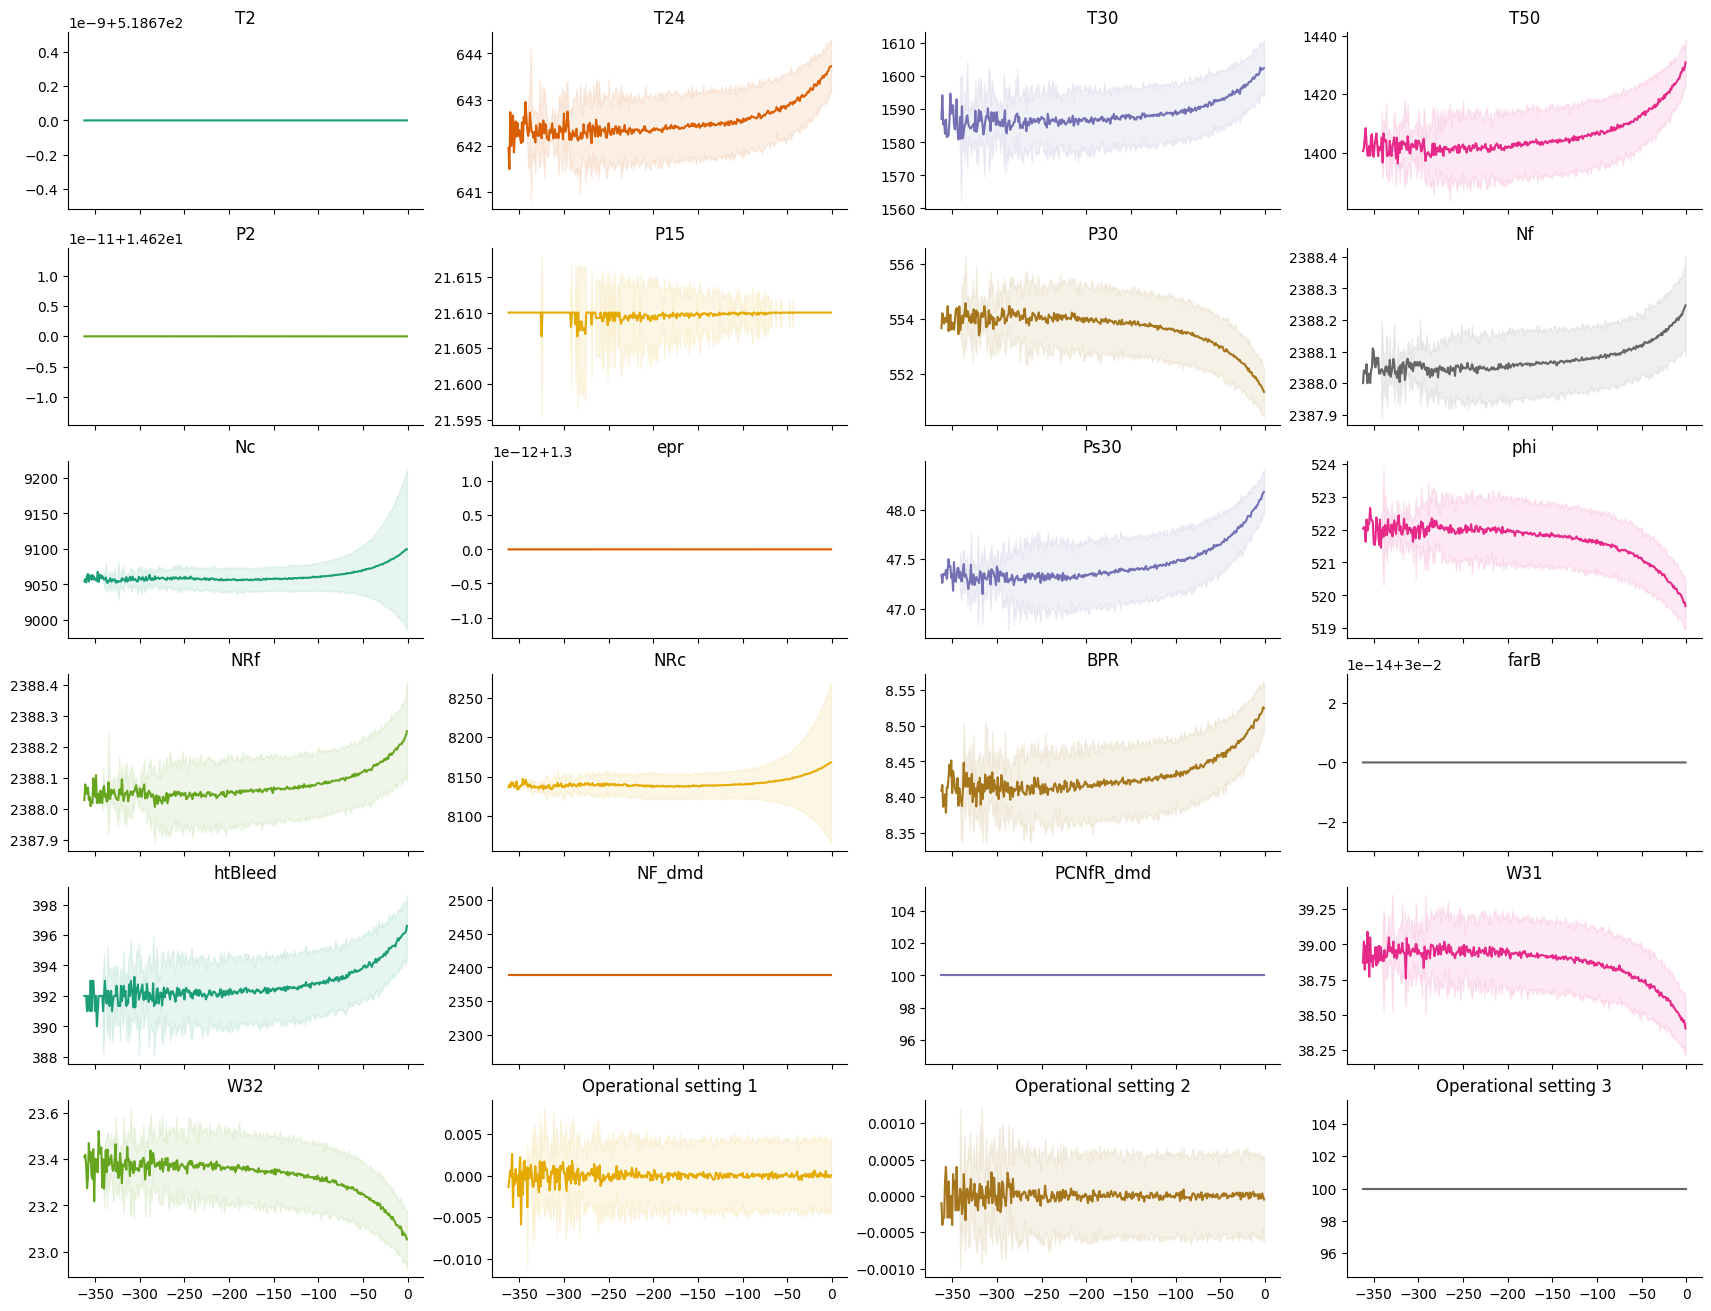

In [8]:
prediction_columns = sensor_columns + operator_columns
cutoff = -362
plt_rows = 6
plt_cols = 4

colors = [mpl.colormaps['Dark2'](i) for i in range(8)]
fig, ax = plt.subplots(plt_rows, plt_cols, sharex = True, figsize = (17, 13),
                       constrained_layout = True)
col_id = 0
for r in range(plt_rows):
    for c in range(plt_cols):
        if col_id > 7:
            col_id = 0
        prediction_column = prediction_columns[r * plt_cols + c]
        pc = train_inverse[[prediction_column]]
        pc = pc.reset_index('Machine id')
        pc_agg = pd.DataFrame({'Inverse time unit': list(range(cutoff, 0)),
                                'Average': [pc.loc[i, prediction_column].mean() for i in range(cutoff, 0)],
                                'Sd': [pc.loc[i, prediction_column].std() for i in range(cutoff, 0)]})
        pc_agg['confidence_low'] = pc_agg['Average'] - 1.96 * pc_agg['Sd']
        pc_agg['confidence_high'] = pc_agg['Average'] + 1.96 * pc_agg['Sd']

        ax[r, c].plot(pc_agg['Inverse time unit'], pc_agg['Average'], color = colors[col_id])
        ax[r, c].fill_between(pc_agg['Inverse time unit'], pc_agg['confidence_low'],
                              pc_agg['confidence_high'], alpha = .1, color = colors[col_id])
        ax[r, c].set_title(prediction_column)
        ax[r, c].spines['top'].set_visible(False)
        ax[r, c].spines['right'].set_visible(False)
        
        col_id += 1

The above plots show that many variables show no specific trend with time (like the Operational settings, farB and T2). Some are even constant, without any variance. They can be excluded from further analysis. Others are interesting and show a similar trend to each other, either positive or negative (like T24, Ps30 and W31). Again an other group of variables show a different yet intereseting trend, and because it's unclear whether we should include or exclude them, they are worth further looking into (NRc, Nc, P15). The remaining set of variables is: 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32'. Also pay attention to the variance (a 95% Interval is used) of every variable, it's quite large.

#### Trend of individual engines (individual plots)
Let's see how every machine behaves individually. Do the individual machines show a similar trend with each other, or is the variance a consequence of machines behaving differently towards failure?

Here we visualize individual machines per sensor variable. We also plot a rolling mean in order to to see a trend. (Now the rolling mean is set to 21 time units, but that's somewhat arbitrary)

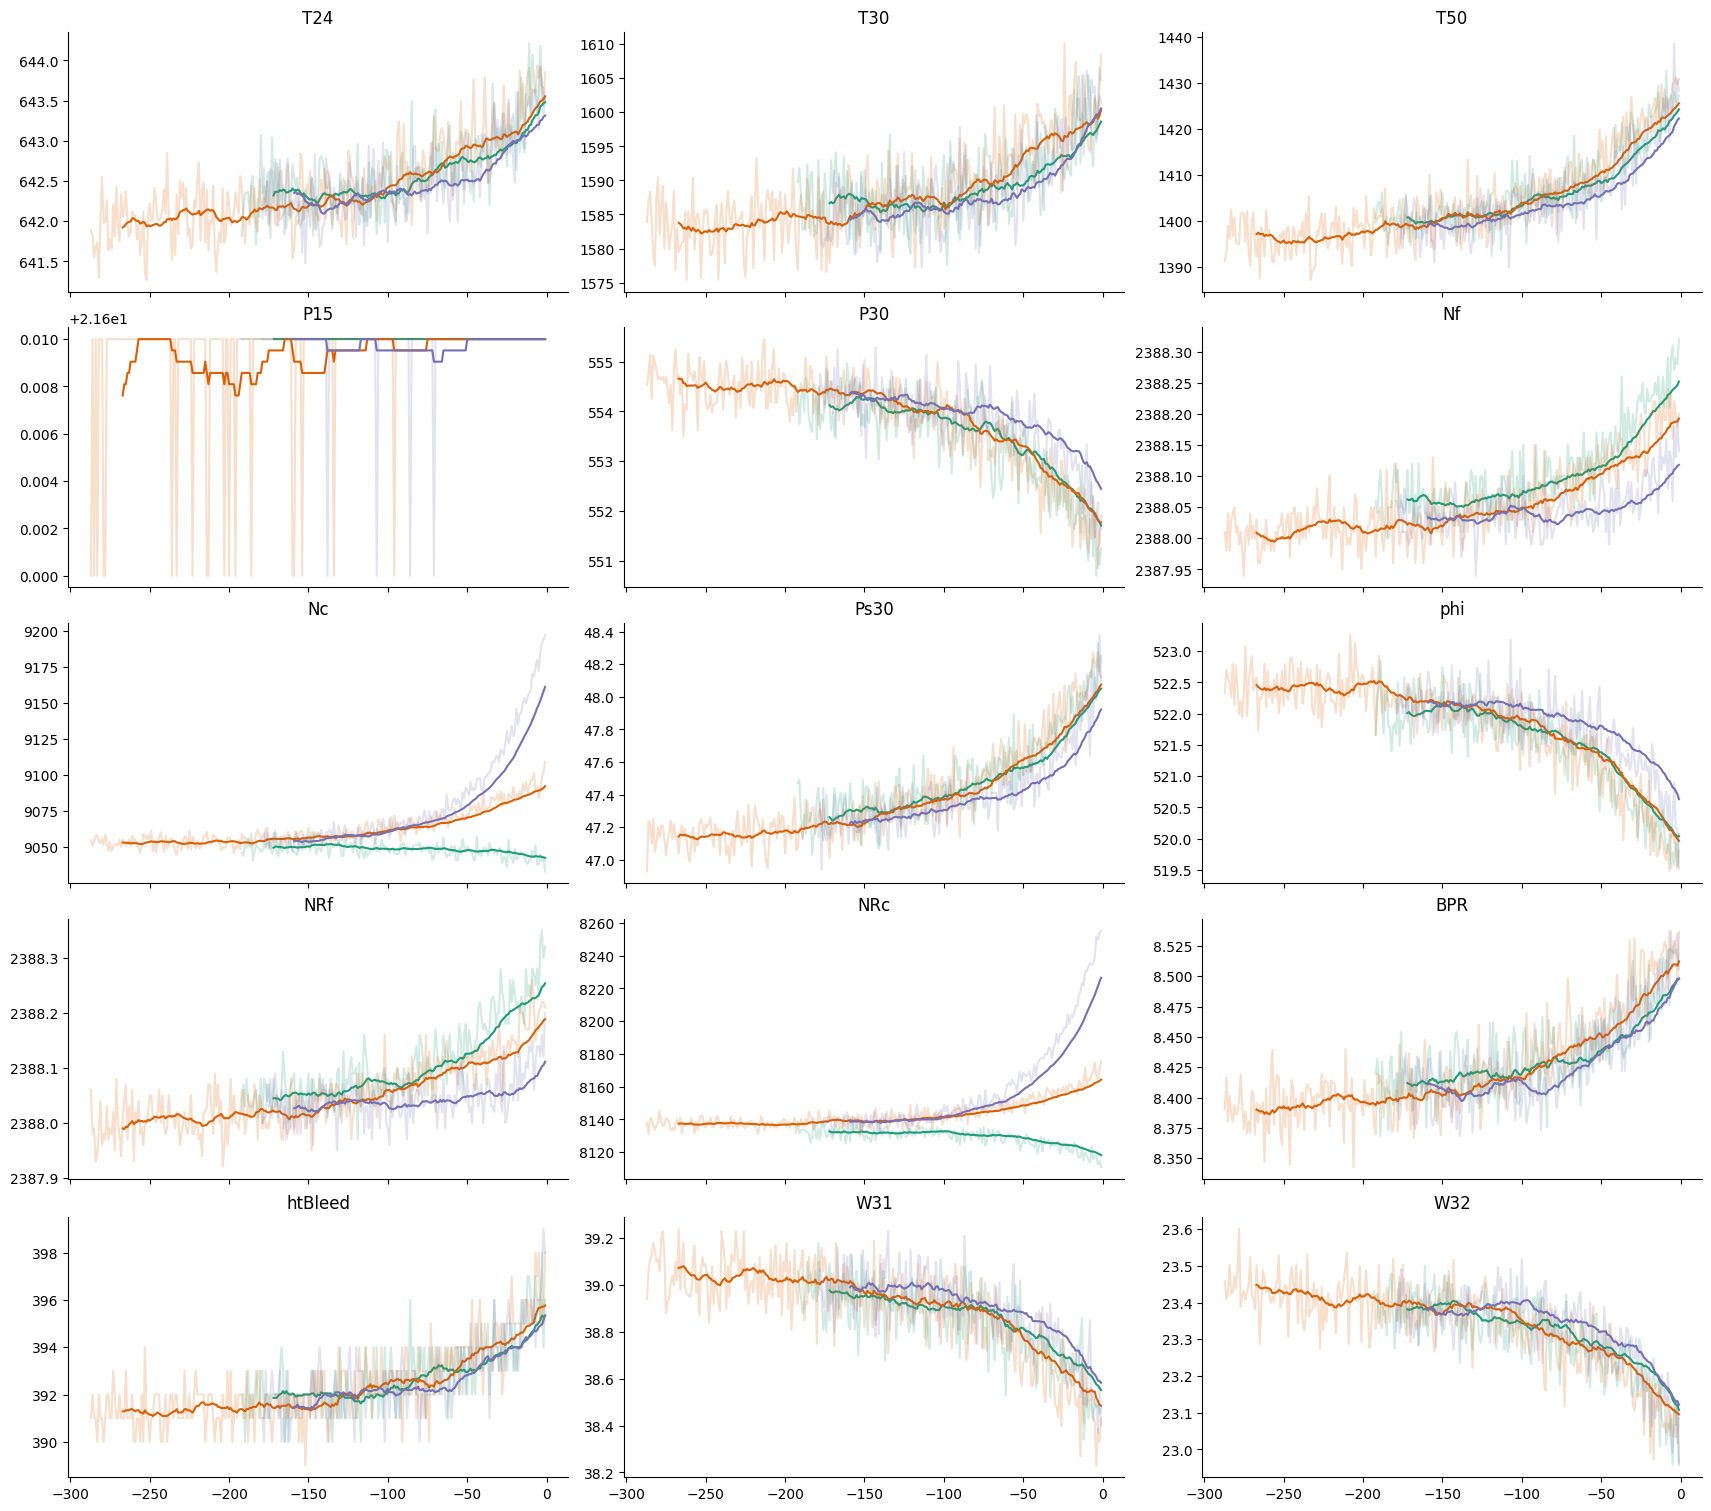

In [9]:
sensor_variables = ['T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']
machine_ids = [1, 2, 3]
plt_rows = 5
plt_cols = 3

fig, ax = plt.subplots(plt_rows, plt_cols, sharex = True, figsize = (17, 15),
                       constrained_layout = True)
for r in range(plt_rows):
    for c in range(plt_cols):
        sensor_variable = [sensor_variables[r * plt_cols + c]]
        col_id = 0
        for i in machine_ids:
            if col_id > 7:
                col_id = 0
            train_inverse_indiv = train_inverse.reset_index('Inverse time unit').loc[i, ['Inverse time unit'] + sensor_variable]
            train_inverse_indiv[sensor_variable[0] + '_rolling'] = train_inverse_indiv[sensor_variable].rolling(21).mean()
            
            ax[r, c].plot(train_inverse_indiv['Inverse time unit'],
                     train_inverse_indiv[sensor_variable],
                     alpha = .2,
                     color = colors[col_id])
            ax[r, c].plot(train_inverse_indiv['Inverse time unit'],
                     train_inverse_indiv[sensor_variable[0] + '_rolling'],
                     color = colors[col_id])
            ax[r, c].set_title(sensor_variable[0])
            ax[r, c].spines['top'].set_visible(False)
            ax[r, c].spines['right'].set_visible(False)
            
            col_id += 1

The above plots confirm the high variance of the measurements of every individual sensor. It looks like that for many sensors the machines show a similar trend towards failure. However, because we plotted only three machines (otherwise the plots become very messy), we are not sure if this is true for all machines. To confirm this, we create another figure, with only the rolling means. Note that NRc and Nc show a different trend for the individual machines, which was already suggested by the aggregated plots.

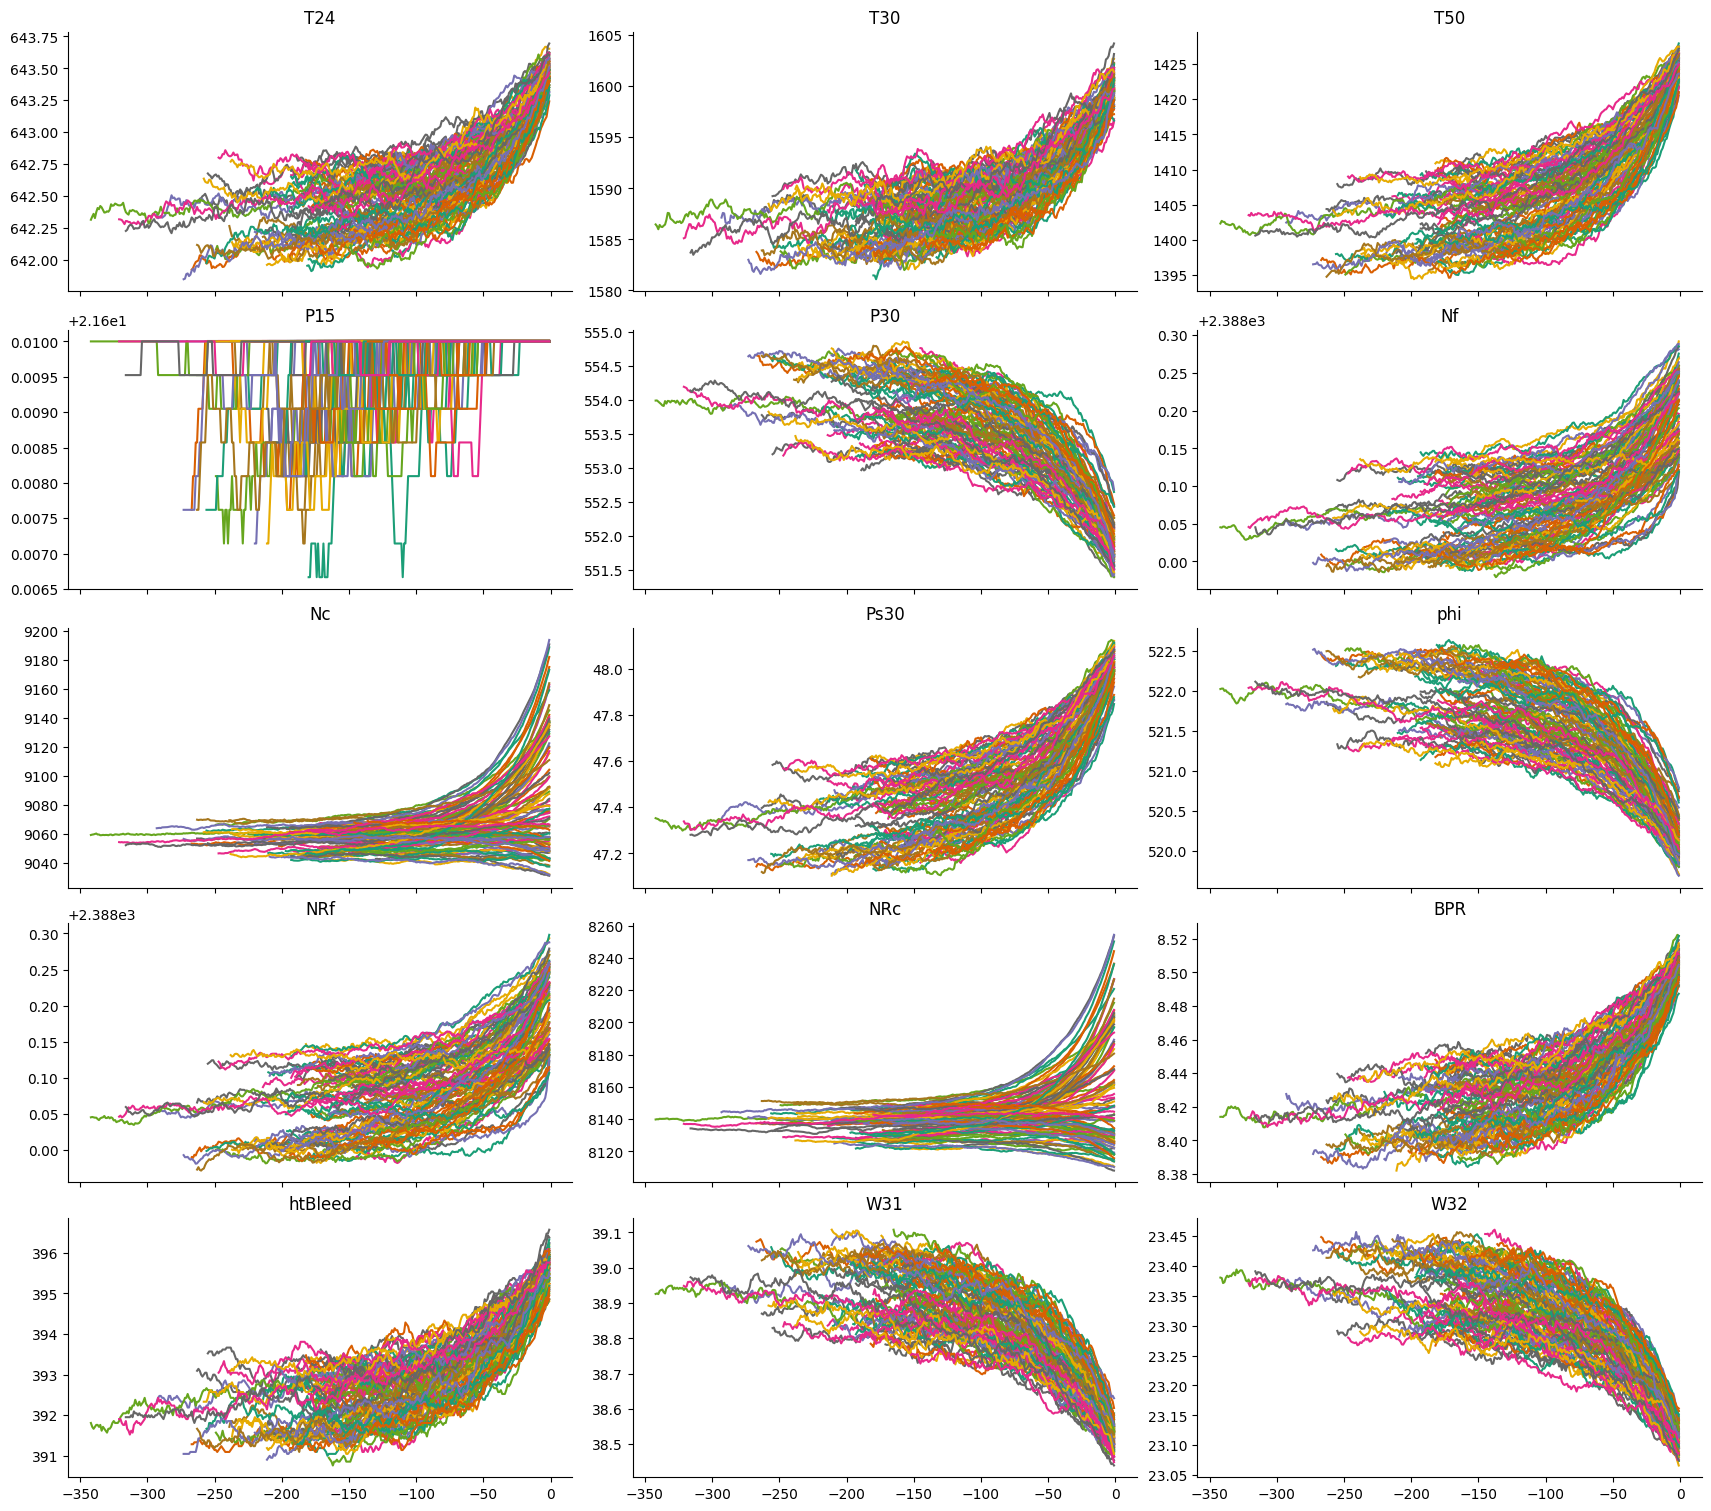

In [10]:
plt_rows = 5
plt_cols = 3

fig, ax = plt.subplots(plt_rows, plt_cols, sharex = True, figsize = (17, 15),
                       constrained_layout = True)
for r in range(plt_rows):
    for c in range(plt_cols):
        sensor_variable = [sensor_variables[r * plt_cols + c]]
        col_id = 0
        for i in train_machine_ids:
            if col_id > 7:
                col_id = 0
            train_inverse_indiv = train_inverse.reset_index('Inverse time unit').loc[i, ['Inverse time unit'] + sensor_variable]
            train_inverse_indiv[sensor_variable[0] + '_rolling'] = train_inverse_indiv[sensor_variable].rolling(21).mean()
            
            ax[r, c].plot(train_inverse_indiv['Inverse time unit'],
                     train_inverse_indiv[sensor_variable[0] + '_rolling'],
                     color = colors[col_id])
            ax[r, c].set_title(sensor_variable[0])
            ax[r, c].spines['top'].set_visible(False)
            ax[r, c].spines['right'].set_visible(False)
            
            col_id += 1

By plotting only the rolling means, all individual machines can be shown. Now you can clearly see that all machines have a different starting point on the x-axis (hence, the fluctuations shown in the aggregated plots). Interestingly, the machines have a different starting point on the y-axis as well, but as time proceeds some converge to an approximately corresponding point. Others show a similar behaviour, but with larger variance towards the end (Nf, NRf). 

### Correlation analysis
Analyze the correlation between sensor variables.

#### Conclusions
- The inter-correlation of the resulting variables is linear.

#### Correlation between sensor variables
From the above analysis, it is clear that for many variables the individual machines show a very similar trend. However, for NRc, Nc and P15, there is a wide variety in variable behaviour towards the point of failure. With this in mind, the next question would/could be: how are the individual sensor measurements correlated? And more importantly: we can clearly see in the plots that the variables are not linearly correlated with the time units, but do the variables correlate linearly with each other? We expect some correlations; let's see how strong they are.

<Axes: >

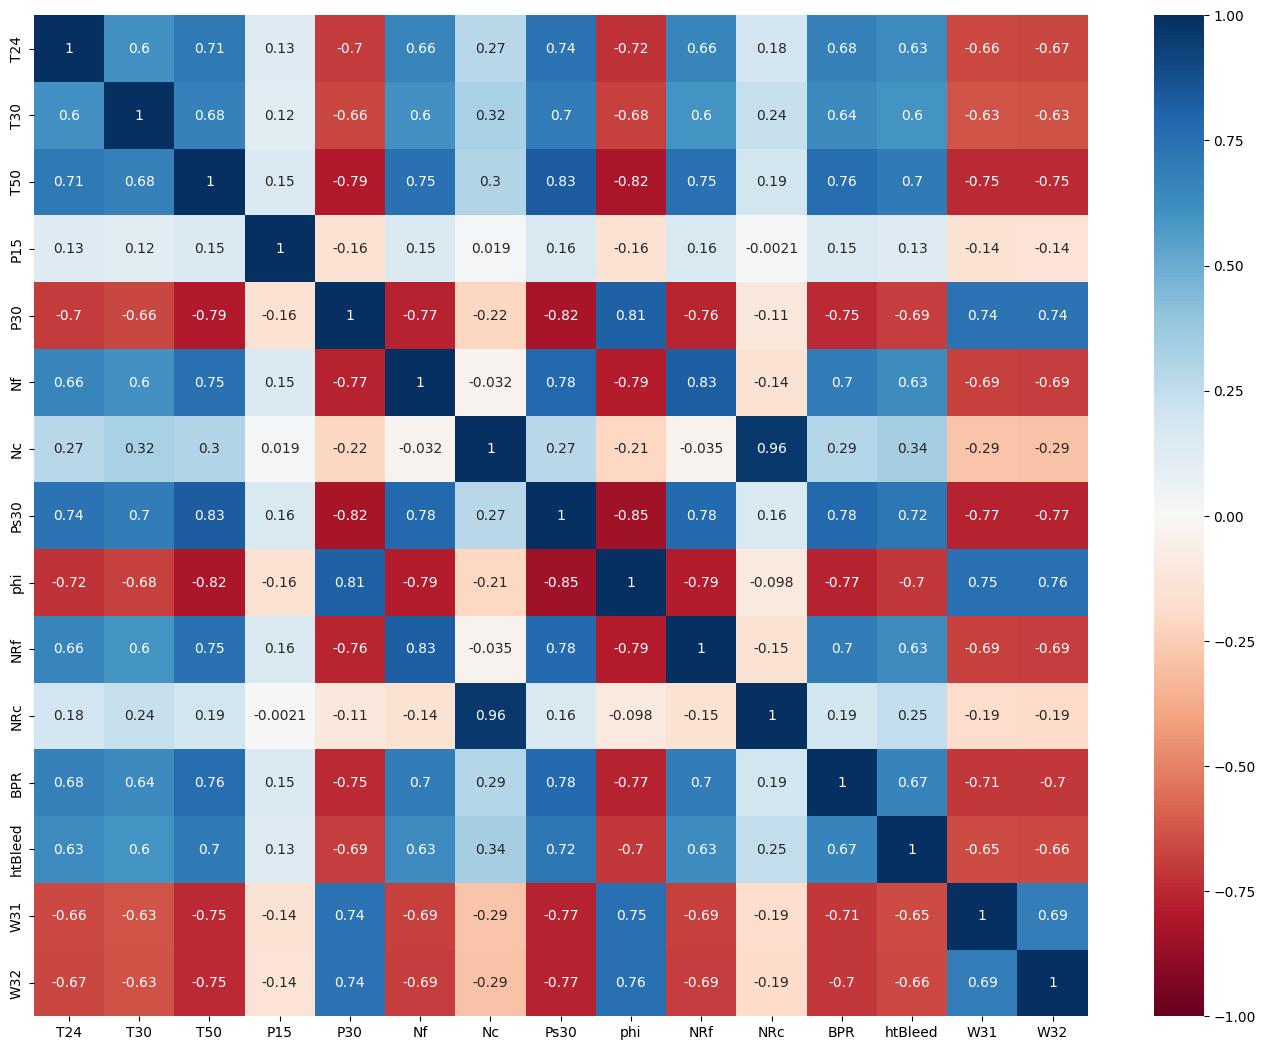

In [11]:
train_inverse_useful = train_inverse[sensor_variables]
tiu_cor = train_inverse_useful.corr()
fig, ax = plt.subplots(figsize = (17, 13))
sns.heatmap(tiu_cor, vmin = -1, vmax = 1, annot = True, cmap = 'RdBu')

It's clear that NRc, Nc and P15 show just a weak correlation with the other variables, and that the inter-correlation of all the other variables are quite high. Now we have two options: 1. We only include weakly correlated variables (because many machine learning models suffer from multicollinearity and dimensionality). 2. We include only variables that show a meaningful trend and apply some dimensionality reduction and therefore keep the variance as high as possible.

We will proceed with option 2.

P15, NRc and Nc do not hold as much information as the other variables. Therefore, for further analysis, we exclude them. It could be interesting though, for another time and another analysis, to include them and see if our final model will take advantage from the information they hold, but that's beyond the scope of this notebook. The remaining set of sensor variables is: 'T24', 'T30', 'T50', 'P30', 'Nf', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32'.

Now let's see if the remaining variables show a <u>linear</u> inter-correlation with each other (this is important for some dimensionality reduction techniques to be applicable). The following code tranforms the correlation matrix into a dataframe with a multi-index which consists of the inter-correlation pairs, in order to simplify the plotting procedure. It also gets rid of intra-correlations (all 1.0 values) and duplicates for clarity. Finally, it sorts the values by their absolute values.

In [12]:
sensor_variables = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32']
train_inverse_useful = train_inverse[sensor_variables]
tiu_cor = train_inverse_useful.corr()
tiu_cor_clean = tiu_cor.unstack().drop_duplicates()
tiu_cor_clean = tiu_cor_clean[tiu_cor_clean < 1].sort_values(ascending = False, key = abs)
tiu_cor_clean

Ps30  phi       -0.846884
T50   Ps30       0.830136
Nf    NRf        0.826084
P30   Ps30      -0.822805
T50   phi       -0.815591
                   ...   
T30   W31       -0.625941
T24   T30        0.602610
T30   Nf         0.602481
      NRf        0.600963
      htBleed    0.600017
Length: 66, dtype: float64

The objective for the next section is to show that the remaining variables are linearly correlated with each other. We want to do this with as least graphs as possible, because if we plot them all we will have to plot 66 graphs and that'll look quite messy. The following code captures the correlation of only 13 correlations. 6 base plots (the graphs inside a box), which all complement each other (each plot has a completely different pair of variables). And also 7 connection plots (the graphs without a box), they connect the base plots which each other, because they contain 1 variable of 2 different base plots.

For example, the first row of plots contain two base plots with two pairs ((phi, Ps30), (NRf, Nf)), they have the same color. And they have a resulting connection plot, containing one variable of each pair in that row (NRf, phi). The rows have two base pairs and there are three rows, so three horizontal connection plots. Same holds for the two columns, they have three base pairs, so four vertical connection plots in total.

If all 13 plots show a linear correlation, we can infer that the remaining 53 plots probably also show a linear correlation.

In [13]:
sens_vars = []
plot_cors = []
cors_plot = []
for idx in range(len(tiu_cor_clean)):
    tmp_vars = list(tiu_cor_clean.index[idx])
    if (tmp_vars[0] in sens_vars) | (tmp_vars[1] in sens_vars):
        continue
    
    sens_vars += tmp_vars
    plot_cors.append(tmp_vars)
    cors_plot.append(tiu_cor_clean[idx])

horizontal_connection_plots = []
hcp_cor = []
vertical_connection_plots = []
vcp_cor = []
for i in [0, 2, 4]:
    idx = 0
    counter = 0
    while counter == 0:
        midx = tiu_cor_clean.index[idx]
        idx += 1
        if ((plot_cors[i][0] in midx) | (plot_cors[i][1] in midx)) & ((plot_cors[i + 1][0] in midx) | (plot_cors[i + 1][1] in midx)):
            horizontal_connection_plots.append(list(midx))
            hcp_cor.append(tiu_cor_clean[idx])
            counter += 1

for i in range(4):
    idx = 0
    counter = 0
    while counter == 0:
        midx = tiu_cor_clean.index[idx]
        idx += 1
        if ((plot_cors[i][0] in midx) | (plot_cors[i][1] in midx)) & ((plot_cors[i + 2][0] in midx) | (plot_cors[i + 2][1] in midx)):
            vertical_connection_plots.append(list(midx))
            vcp_cor.append(tiu_cor_clean[idx])
            counter += 1

base_plot_vars = [item for sublist in plot_cors for item in sublist]

for i in range(len(horizontal_connection_plots)):
    plot_cors.insert(3 * i + 2, horizontal_connection_plots[i])
    cors_plot.insert(3 * i + 2, hcp_cor[i])


plot_cors.insert(9, vertical_connection_plots[0])
cors_plot.insert(9, vcp_cor[0])
plot_cors.insert(10, vertical_connection_plots[1])
cors_plot.insert(10, vcp_cor[1])
plot_cors.insert(11, [])
cors_plot.insert(11, 0)
plot_cors.insert(12, vertical_connection_plots[2])
cors_plot.insert(12, vcp_cor[2])
plot_cors.insert(13, vertical_connection_plots[3])
cors_plot.insert(13, vcp_cor[3])

It could be interesting to show how the <u>individual</u> machines correlate with each other, therefore we also plot these for one single machine. The blue dots represent all rows in the dataset, the red dots are a single machines (machine 1).

(0.0, 1.0, 0.0, 1.0)

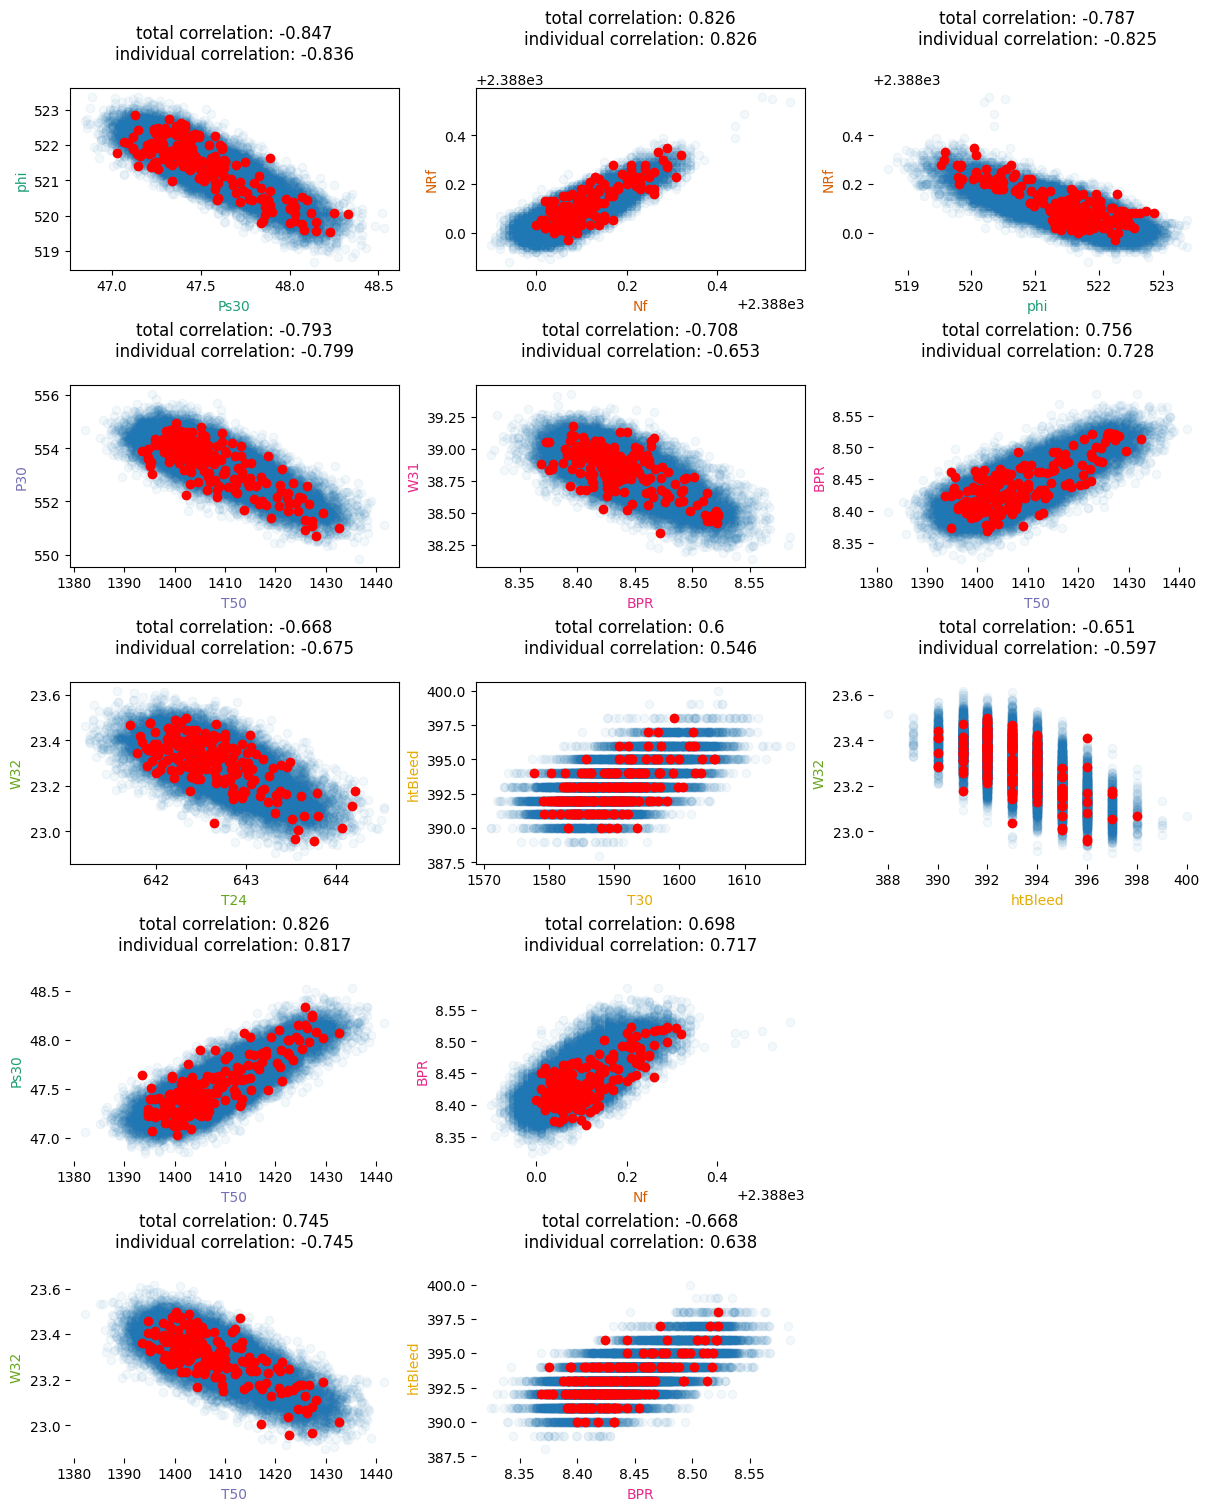

In [14]:
machine_id = 1
plt_rows = 5
plt_cols = 3

fig, ax = plt.subplots(plt_rows, plt_cols, figsize = (12, 15),
                       constrained_layout = True)

paired_colors = [[] for _ in range(len(base_plot_vars))]
c_counter = 0
pc_counter = 0
while c_counter < 6:
    paired_colors[pc_counter] = colors[c_counter]
    pc_counter += 1
    paired_colors[pc_counter] = colors[c_counter]
    pc_counter += 1
    c_counter += 1

for r in range(plt_rows):
    for c in range(plt_cols):
        i = r * plt_cols + c
        if (i < len(plot_cors)) & (i != 11):
            correlation_features = plot_cors[i]
            indiv_cor = train.loc[machine_id, correlation_features].corr().iloc[0, 1]
            ax[r, c].scatter(x = train[correlation_features[0]],
                             y = train[correlation_features[1]],
                             alpha = .05)
            ax[r, c].scatter(x = train.loc[machine_id, correlation_features[0]],
                             y = train.loc[machine_id, correlation_features[1]],
                             color = 'r')
            ax[r, c].set_title('total correlation: {}\nindividual correlation: {}\n'.
                               format(round(cors_plot[i], 3), round(indiv_cor, 3)))
            ax[r, c].set_xlabel(correlation_features[0], color = paired_colors[base_plot_vars.index(correlation_features[0])])
            ax[r, c].set_ylabel(correlation_features[1], color = paired_colors[base_plot_vars.index(correlation_features[1])])
            if (r > 2) | (c > 1):
                ax[r, c].spines['top'].set_visible(False)
                ax[r, c].spines['right'].set_visible(False)
                ax[r, c].spines['bottom'].set_visible(False)
                ax[r, c].spines['left'].set_visible(False)

ax[-1, -1].axis('off')
ax[-2, -1].axis('off')

All the plots seem to show a linear relationship. Therefore, probably all correlations are approximatley linear.

### Visualise machine lifetimes (train + test)
Are the lifetimes of the train- and testengines equally distributed?

#### Conclusion
The distributions of the train and test set are equally distributed.

In [15]:
machine_lifetimes_train = train.groupby(level = 'Machine id').size()
machine_lifetimes_train

Machine id
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Length: 100, dtype: int64

The test set consists of data with a random stopping point. The target data consists of the Remaining Useful Lifetimes (RUL) from that random stopping point onwards. Threfore, the total lifetime of that machine is the sum of the random stopping point and the RUL.

In [16]:
random_stopping_points = test.groupby(level = 'Machine id').size()
machine_lifetimes_test = random_stopping_points + target['RUL']
machine_lifetimes_test

Machine id
101    143
102    147
103    195
104    188
105    189
      ... 
196    234
197    216
198    180
199    214
200    218
Length: 100, dtype: int64

Comparing the lifetime descriptive statistics and distributions of the train and test sets.

In [17]:
machine_lifetimes = pd.DataFrame({'train': machine_lifetimes_train, 'test': machine_lifetimes_test}).reset_index(drop = True)
machine_lifetimes.describe()

train        test
count  100.000000  100.000000
mean   206.310000  206.480000
std     46.342749   44.041872
min    128.000000  141.000000
25%    177.000000  174.750000
50%    199.000000  199.000000
75%    229.250000  227.750000
max    362.000000  341.000000

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

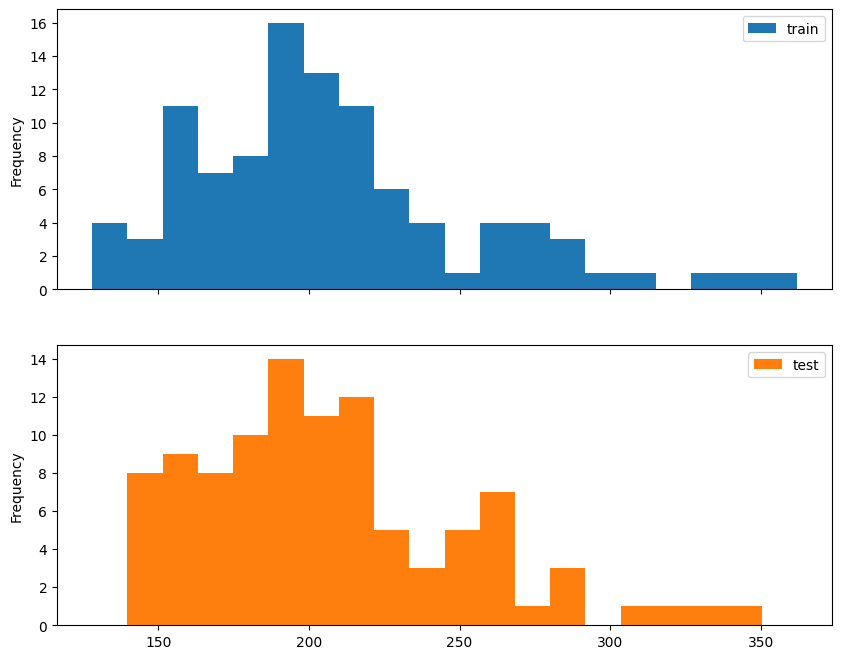

In [18]:
machine_lifetimes.plot.hist(bins = 20, subplots = True, figsize = (10, 8))

The Kolmogorov-Smirnov test is especially developed to test whether two samples come from the same population distribution.

In [19]:
stats.ks_2samp(machine_lifetimes['train'], machine_lifetimes['test'])

KstestResult(statistic=0.03, pvalue=0.9999920612641017, statistic_location=214.0, statistic_sign=1)

The test statistic is the maximum deviation between both samples.
The p-value relates to the null hypothesis that the samples are drawn from te same population distribution.
Since p > .05, we can't reject the null hypothesis.
Actually, the p-value is so high that this gives high confidence that both samples come from the same population.

### Statistical fit to (train) machine lifetimes
Try to come up with a type of distribution that describes the data well.

#### Conclusion
We fitted a Weibull distrubution (often used in reliability engineering) to the data, it shows a pretty good fit and can be used for this. Note however, that the Weibull distribution should start at zero, while we moved it over the time-axis voilating the Weibull assumptions. We accept this violation for now.

Below, curve_fit on the cdf is used, because the optimization of stats.weibull_min.fit(machine_lifetimes_train) gave meaningless parameters. When the optimization with a cdf is used, an approximation can be used as starting point, which results in meaningful parameters.

In [20]:
xx = np.linspace(100, 400, 300)
mlt_cdf = [((machine_lifetimes_train < x).sum()) / len(machine_lifetimes_train) for x in xx]

weibull_params = optimize.curve_fit(stats.weibull_min.cdf, xx, mlt_cdf, [3, 120, 80])[0]
weibull_params

array([  1.63237321, 136.18672758,  77.6995994 ])

Showing the cdf fit.

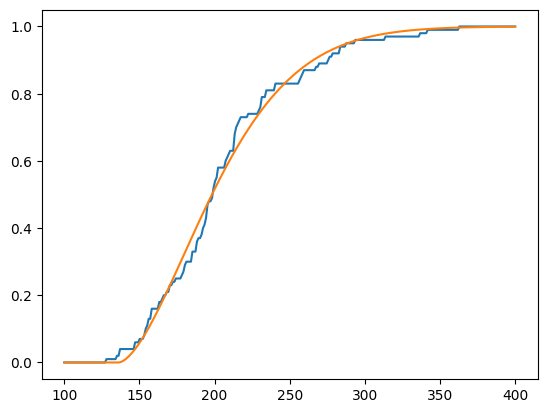

In [21]:
plt.plot(xx, mlt_cdf)
plt.plot(xx, stats.weibull_min.cdf(xx, *weibull_params))
plt.show()

Showing the fit on a pdf.

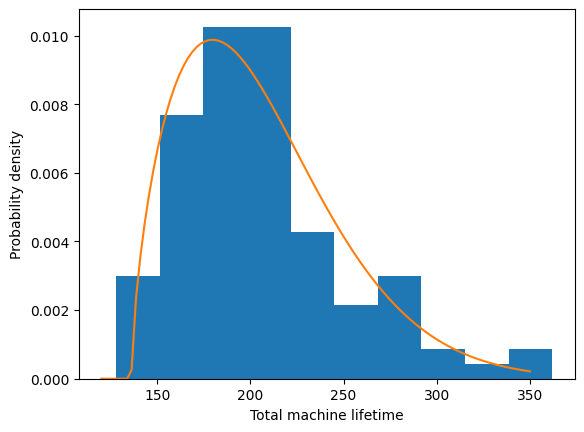

In [22]:
x = np.linspace(120,350,100)
plt.hist(machine_lifetimes_train, density=True)
plt.plot(x, stats.weibull_min.pdf(x, *weibull_params))
plt.xlabel('Total machine lifetime')
plt.ylabel('Probability density')
plt.show()

### Conclusions
- For now we will exclude NRc, Nc, P15 from further analysis, because we have chosen Option 2. Which means we want to use dimensionality reduction, with only columns which show a strong trend with time, and which are linearly correlated.
- So the resulting set of predicitive sensor variables is 'T24', 'T30', 'T50', 'P30', 'Nf', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32'.
- The resulting variables show a strong either positive or negative linear correlation with each other.
- The aggregated and individual plots show a lot of error, which must be kept in mind for further analysis.
- Despite the fitted Weibull distribution doesn't start at zero, it shows a pretty good fit and can be used accordingly.

## Data preparation & modelling

### Dimensionality Reduction

#### Conclusions
- Just one principal component covers 86% (!) of all the variance in the remaining data.
- Only the first component clearly shows a trend with engine decay.
- Despite the fact that all machines show a similar trend towards failure, there is still al lot of variance between machines in terms of starting point and decay pace. Which makes modeling tough. Also, there is a lot of noise within the machines themselves.

We will use PCA for dimensionality reduction. This works well with linearly correlated values.

In [23]:
prediction_columns = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32']
train_inverse = train_inverse[prediction_columns]
pca = PCA()
train_pca = pca.fit_transform(train_inverse).transpose()

Show how much variance each of the principal components hold.

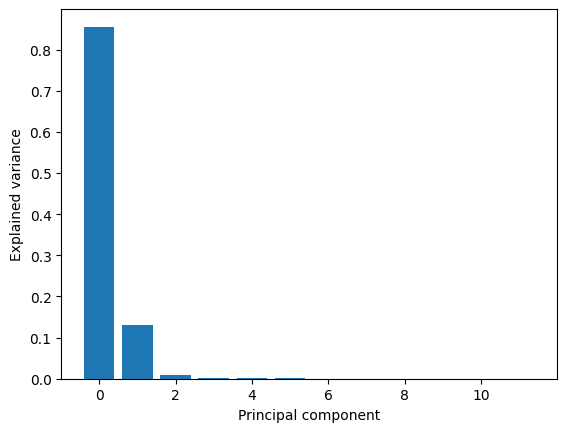

In [24]:
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

We see that the first principal component contains 86% of the variance in the data. The second principal component could also be important for predicting engine decay (around 13% of the variance). So let's inspect if they both show a trend with engine decay.

It's convenient to first do some data wrangling to simplify the visualization procedure. Below, the principal components are added to the data, the rolling mean of these components are computed, and the inverse time unit is used as a column.

In [25]:
train_inverse['PC1'] = train_pca[0]
train_inverse['PC2'] = train_pca[1]
train_inverse['PC1_rolling'] = np.array(train_inverse.groupby(level = 'Machine id')[['PC1']].rolling(21).mean())
train_inverse['PC2_rolling'] = np.array(train_inverse.groupby(level = 'Machine id')[['PC2']].rolling(21).mean())
train_inverse['ITU'] = np.array(train_inverse.reset_index('Inverse time unit')['Inverse time unit'])
train_inverse

T24      T30      T50     P30       Nf  \
Machine id Inverse time unit                                              
1          -192               641.82  1589.70  1400.60  554.36  2388.06   
           -191               642.15  1591.82  1403.14  553.75  2388.04   
           -190               642.35  1587.99  1404.20  554.26  2388.08   
           -189               642.35  1582.79  1401.87  554.45  2388.11   
           -188               642.37  1582.85  1406.22  554.00  2388.06   
...                              ...      ...      ...     ...      ...   
100        -5                 643.49  1597.98  1428.63  551.43  2388.19   
           -4                 643.54  1604.50  1433.58  550.86  2388.23   
           -3                 643.42  1602.46  1428.18  550.94  2388.24   
           -2                 643.23  1605.26  1426.53  550.68  2388.25   
           -1                 643.85  1600.38  1432.14  550.79  2388.26   

                               Ps30     phi      NRf     BPR  htBleed    W31  \
Machine id Inverse time unit                                                   
1          -192               47.47  521.66  2388.02  8.4195      392  39.06   
           -191               47.49  522.28  2388.07  8.4318      392  39.00   
           -190               47.27  522.42  2388.03  8.4178      390  38.95   
           -189               47.13  522.86  2388.08  8.3682      392  38.88   
           -188               47.28  522.19  2388.04  8.4294      393  38.90   
...                             ...     ...      ...     ...      ...    ...   
100        -5                 48.07  519.49  2388.26  8.4956      397  38.49   
           -4                 48.04  519.68  2388.22  8.5139      395  38.30   
           -3                 48.09  520.01  2388.24  8.5646      398  38.44   
           -2                 48.39  519.67  2388.23  8.5389      395  38.29   
           -1                 48.20  519.30  2388.26  8.5036      396  38.37   

                                  W32        PC1       PC2  PC1_rolling  \
Machine id Inverse time unit                                              
1          -192               23.4190  -7.800385  3.446253          NaN   
           -191               23.4236  -4.559961  4.015494          NaN   
           -190               23.3442  -5.804056  0.163470          NaN   
           -189               23.3739 -10.186059 -3.172352          NaN   
           -188               23.4044  -6.244623 -5.291379          NaN   
...                               ...        ...       ...          ...   
100        -5                 22.9735  21.270477 -3.368728    16.847880   
           -4                 23.1594  28.536723 -0.196295    17.421159   
           -3                 22.9333  23.208698  0.740849    18.039164   
           -2                 23.0640  22.884492  3.980925    18.447106   
           -1                 23.0522  25.424049 -3.045894    18.813632   

                              PC2_rolling  ITU  
Machine id Inverse time unit                    
1          -192                       NaN -192  
           -191                       NaN -191  
           -190                       NaN -190  
           -189                       NaN -189  
           -188                       NaN -188  
...                                   ...  ...  
100        -5                   -0.179880   -5  
           -4                   -0.343561   -4  
           -3                   -0.182447   -3  
           -2                    0.157731   -2  
           -1                    0.004673   -1  

[20631 rows x 17 columns]

Now let's visualize the principal components in the same way we did for all the sensor variables. With the inverse time unit and a confidence interval of 95%.

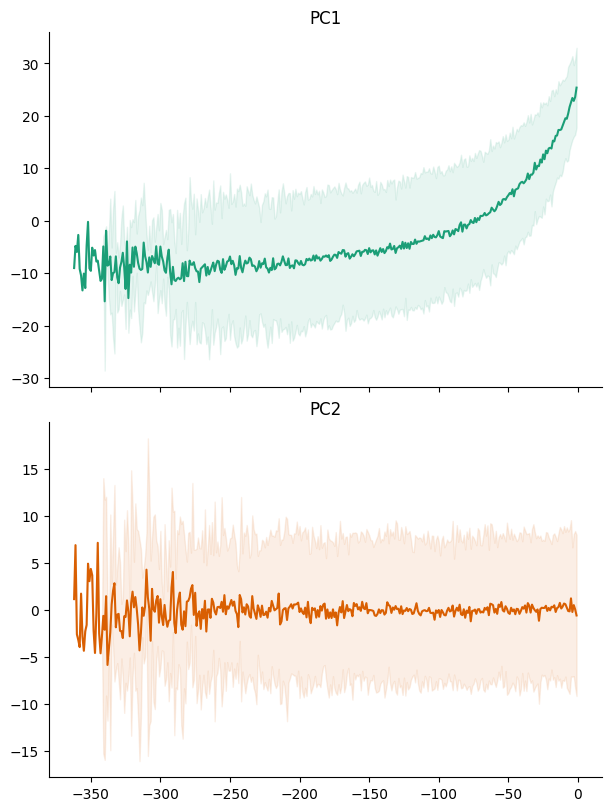

In [26]:
principal_components = ['PC1', 'PC2']
cutoff = -362
plt_rows = 2
plt_cols = 1

fig, ax = plt.subplots(plt_rows, plt_cols, sharex = True, figsize = (6, 8),
                       constrained_layout = True)
col_id = 0
for r in range(plt_rows):
    principal_component = principal_components[r]
    pc = train_inverse[[principal_component]]
    pc = pc.reset_index('Machine id')
    pc_agg = pd.DataFrame({'Inverse time unit': list(range(cutoff, 0)),
                            'Average': [pc.loc[i, principal_component].mean() for i in range(cutoff, 0)],
                            'Sd': [pc.loc[i, principal_component].std() for i in range(cutoff, 0)]})
    pc_agg['confidence_low'] = pc_agg['Average'] - 1.96 * pc_agg['Sd']
    pc_agg['confidence_high'] = pc_agg['Average'] + 1.96 * pc_agg['Sd']

    ax[r].plot(pc_agg['Inverse time unit'], pc_agg['Average'], color = colors[col_id])
    ax[r].fill_between(pc_agg['Inverse time unit'], pc_agg['confidence_low'],
                          pc_agg['confidence_high'], alpha = .1, color = colors[col_id])
    ax[r].set_title(principal_component)
    ax[r].spines['top'].set_visible(False)
    ax[r].spines['right'].set_visible(False)
    
    col_id += 1

The first principal component behaves like a real engine decay signal. The second appears completely uncorrelated with engine decay. As expected, the variance for the principal components are quite large (95% Intervals are used). Let's see how every machine behaves individually. Do the individual machines show a similar trend with each other, or is the variance a consequence of machines behaving differently towards failure?

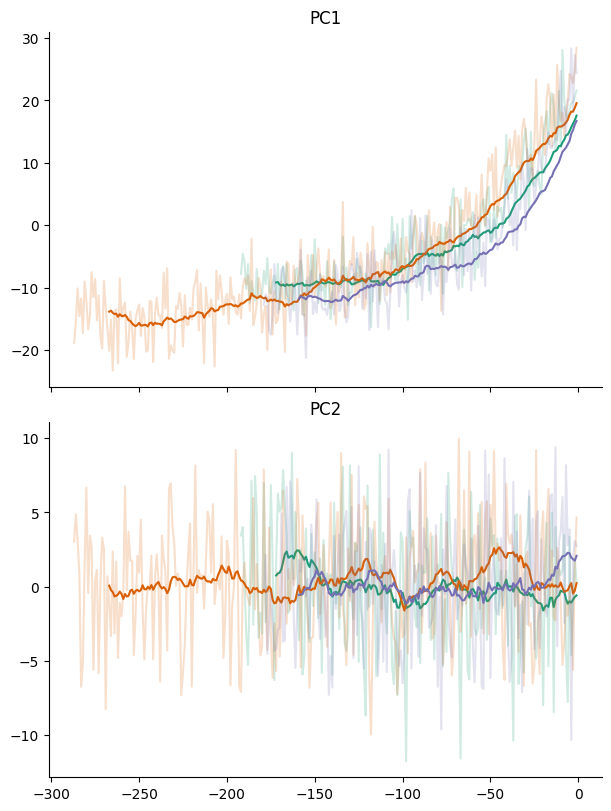

In [27]:
machine_ids = [1, 2, 3]

fig, ax = plt.subplots(2, 1, sharex = True, figsize = (6, 8),
                       constrained_layout = True)
for pc in range(len(principal_components)):
    col_id = 0
    for i in machine_ids:
        ax[pc].plot(train_inverse.loc[i, 'ITU'],
                    train_inverse.loc[i, principal_components[pc]],
                    color = colors[col_id],
                    alpha = .2)
        ax[pc].plot(train_inverse.loc[i, 'ITU'],
                    train_inverse.loc[i, principal_components[pc] + '_rolling'],
                    color = colors[col_id])
        ax[pc].set_title(principal_components[pc])
        ax[pc].spines['top'].set_visible(False)
        ax[pc].spines['right'].set_visible(False)
        
        col_id += 1

The above plots confirm that the first component is a very useful signal; the second seems not. Also, it confirms the high variance shown in the aggregated plot. However, because we only plotted just three machines (otherwise the plot becomes very messy), we are not sure if this is true for all machines. To confirm this, we just need to plot another figure, with only the rolling means, so we can plot a lot more machines, without the plot being messy.

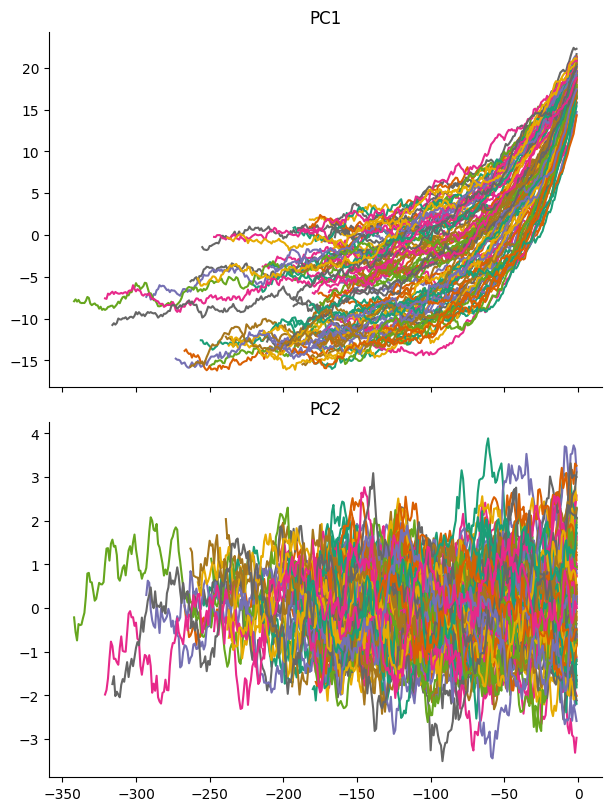

In [28]:
plt_rows = 2
plt_cols = 1

fig, ax = plt.subplots(plt_rows, plt_cols, sharex = True, figsize = (6, 8),
                       constrained_layout = True)
for r in range(plt_rows):
    principal_component = [principal_components[r]]
    col_id = 0
    for i in train_machine_ids:
        if col_id > 7:
            col_id = 0
        train_inverse_indiv = train_inverse.reset_index('Inverse time unit').loc[i, ['Inverse time unit'] + 
                                                                                 principal_component]
        train_inverse_indiv[principal_component[0] +
                            '_rolling'] = train_inverse_indiv[principal_component].rolling(21).mean()

        ax[r].plot(train_inverse_indiv['Inverse time unit'],
                 train_inverse_indiv[principal_component[0] + '_rolling'],
                 color = colors[col_id])
        ax[r].set_title(principal_component[0])
        ax[r].spines['top'].set_visible(False)
        ax[r].spines['right'].set_visible(False)

        col_id += 1

Below a scatter plot of the first (x-axis) and second (y-axis) PC at the point of failure.

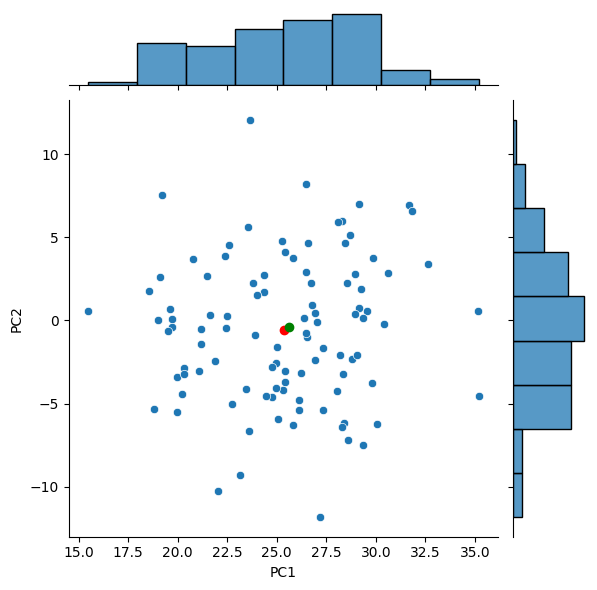

In [29]:
last_time_points = train_inverse.loc[train_inverse['ITU'] == -1, ['PC1', 'PC2']]
p = sns.jointplot(data = last_time_points, x = 'PC1', y = 'PC2')

ltp_mean = last_time_points.mean()
ltp_median = last_time_points.median()
p.ax_joint.plot(ltp_mean[0], ltp_mean[1], 'or')
p.ax_joint.plot(ltp_median[0], ltp_median[1], 'og')

This plot shows the distributions of the principal components at the point of failure. It's not normal distributed, but it shows a tendency towards it. Also, the mean and median are very close to each other.

To confirm that the first PC has strong predictive power and the second PC has not, below shows a scatter plot of different time points before maintenance/failure, along with their mean.

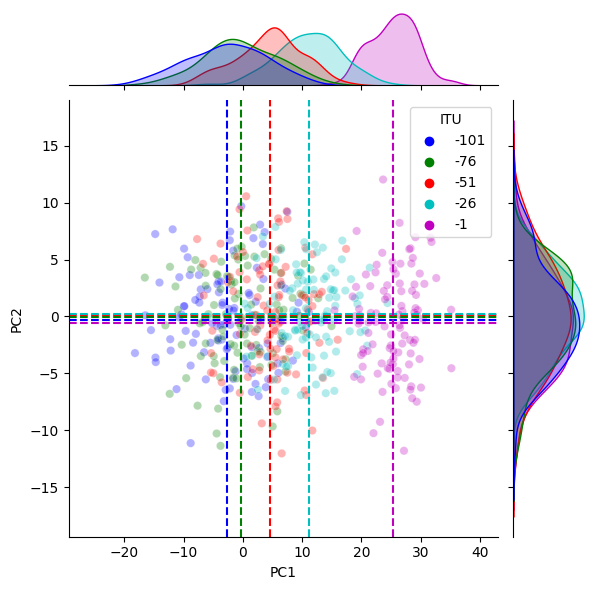

In [30]:
time_points = list(range(-101, 0, 25))
colors = ['b', 'g', 'r', 'c', 'm']
multiple_time_points = pd.concat([train_inverse.loc[train_inverse['ITU'] == i, ['PC1', 'PC2', 'ITU']]
                                 for i in time_points])
p = sns.jointplot(data = multiple_time_points, x = 'PC1', y = 'PC2', hue = 'ITU',
                  palette = colors, alpha = .3)

mtp_means = multiple_time_points.groupby('ITU').mean()
vertical_coord = [mtp_means.loc[i, 'PC1'] for i in time_points]
horizontal_coord = [mtp_means.loc[i, 'PC2'] for i in time_points]
for i in range(5):
    p.ax_joint.axvline(x = vertical_coord[i], color = colors[i], linestyle = 'dashed')
    p.ax_joint.axhline(y = horizontal_coord[i], color = colors[i], linestyle = 'dashed')

We conclude that the value of first principal component behaves like a decay signal. The second principal component stays zero on average over time and gives no worthy information. We also conclude that the decay signal (first principal component) seems to go up to a joined point of failure. From now on, we will exclude the second principal component for further analysis.

To show how the test data behaves over time, it's good practice to plot those lines on top of the train data. However, we don't know when the engines in the test data will fail. That's why we have to plot the data on their original time unit (not inversed). Because we want to show how every individual (test and train) machine behaves over time, the rolling mean is used (in order for the plot not be too messy). Keep in mind that this results in different (more analogous) 'last time points' than the above plots display.

In [31]:
train_inverse['Time unit'] = np.asarray(train.reset_index(level = 'Time unit')['Time unit'])
train_inverse

T24      T30      T50     P30       Nf  \
Machine id Inverse time unit                                              
1          -192               641.82  1589.70  1400.60  554.36  2388.06   
           -191               642.15  1591.82  1403.14  553.75  2388.04   
           -190               642.35  1587.99  1404.20  554.26  2388.08   
           -189               642.35  1582.79  1401.87  554.45  2388.11   
           -188               642.37  1582.85  1406.22  554.00  2388.06   
...                              ...      ...      ...     ...      ...   
100        -5                 643.49  1597.98  1428.63  551.43  2388.19   
           -4                 643.54  1604.50  1433.58  550.86  2388.23   
           -3                 643.42  1602.46  1428.18  550.94  2388.24   
           -2                 643.23  1605.26  1426.53  550.68  2388.25   
           -1                 643.85  1600.38  1432.14  550.79  2388.26   

                               Ps30     phi      NRf     BPR  htBleed    W31  \
Machine id Inverse time unit                                                   
1          -192               47.47  521.66  2388.02  8.4195      392  39.06   
           -191               47.49  522.28  2388.07  8.4318      392  39.00   
           -190               47.27  522.42  2388.03  8.4178      390  38.95   
           -189               47.13  522.86  2388.08  8.3682      392  38.88   
           -188               47.28  522.19  2388.04  8.4294      393  38.90   
...                             ...     ...      ...     ...      ...    ...   
100        -5                 48.07  519.49  2388.26  8.4956      397  38.49   
           -4                 48.04  519.68  2388.22  8.5139      395  38.30   
           -3                 48.09  520.01  2388.24  8.5646      398  38.44   
           -2                 48.39  519.67  2388.23  8.5389      395  38.29   
           -1                 48.20  519.30  2388.26  8.5036      396  38.37   

                                  W32        PC1       PC2  PC1_rolling  \
Machine id Inverse time unit                                              
1          -192               23.4190  -7.800385  3.446253          NaN   
           -191               23.4236  -4.559961  4.015494          NaN   
           -190               23.3442  -5.804056  0.163470          NaN   
           -189               23.3739 -10.186059 -3.172352          NaN   
           -188               23.4044  -6.244623 -5.291379          NaN   
...                               ...        ...       ...          ...   
100        -5                 22.9735  21.270477 -3.368728    16.847880   
           -4                 23.1594  28.536723 -0.196295    17.421159   
           -3                 22.9333  23.208698  0.740849    18.039164   
           -2                 23.0640  22.884492  3.980925    18.447106   
           -1                 23.0522  25.424049 -3.045894    18.813632   

                              PC2_rolling  ITU  Time unit  
Machine id Inverse time unit                               
1          -192                       NaN -192          1  
           -191                       NaN -191          2  
           -190                       NaN -190          3  
           -189                       NaN -189          4  
           -188                       NaN -188          5  
...                                   ...  ...        ...  
100        -5                   -0.179880   -5        196  
           -4                   -0.343561   -4        197  
           -3                   -0.182447   -3        198  
           -2                    0.157731   -2        199  
           -1                    0.004673   -1        200  

[20631 rows x 18 columns]

In [32]:
test_inverse = test.reset_index('Time unit')
test_inverse['Inverse time unit'] = test_inverse.groupby(level = 'Machine id')['Time unit'].transform(lambda x:
                                                                                                      (x - np.max(x)) - 1)
test_inverse = test_inverse.set_index('Inverse time unit', append = True).drop(['Time unit'], axis = 1)

test_inverse = test_inverse.loc[:, prediction_columns]

test_inverse['PC1'] = pca.transform(test_inverse).transpose()[0]
test_inverse['Time unit'] = np.array(test.reset_index(level = 'Time unit')['Time unit'])
test_inverse

T24      T30      T50     P30       Nf  \
Machine id Inverse time unit                                              
101        -31                643.02  1585.29  1398.21  553.90  2388.04   
           -30                641.71  1588.45  1395.42  554.85  2388.01   
           -29                642.46  1586.94  1401.34  554.11  2388.05   
           -28                642.44  1584.12  1406.42  554.07  2388.03   
           -27                642.51  1587.19  1401.92  554.16  2388.01   
...                              ...      ...      ...     ...      ...   
200        -5                 643.24  1599.45  1415.79  553.41  2388.02   
           -4                 643.22  1595.69  1422.05  553.22  2388.05   
           -3                 643.44  1593.15  1406.82  553.04  2388.11   
           -2                 643.26  1594.99  1419.36  553.37  2388.07   
           -1                 642.95  1601.62  1424.99  552.48  2388.06   

                               Ps30     phi      NRf     BPR  htBleed    W31  \
Machine id Inverse time unit                                                   
101        -31                47.20  521.72  2388.03  8.4052      392  38.86   
           -30                47.50  522.16  2388.06  8.3803      393  39.02   
           -29                47.50  521.97  2388.03  8.4441      393  39.08   
           -28                47.28  521.38  2388.05  8.3917      391  39.00   
           -27                47.31  522.15  2388.03  8.4031      390  38.99   
...                             ...     ...      ...     ...      ...    ...   
200        -5                 47.69  520.69  2388.00  8.4715      394  38.65   
           -4                 47.60  521.05  2388.09  8.4512      395  38.57   
           -3                 47.57  521.18  2388.04  8.4569      395  38.62   
           -2                 47.61  521.33  2388.08  8.4711      395  38.66   
           -1                 47.80  521.07  2388.05  8.4903      396  38.70   

                                  W32        PC1  Time unit  
Machine id Inverse time unit                                 
101        -31                23.3735 -11.954407          1  
           -30                23.3916 -12.810482          2  
           -29                23.4166  -8.395258          3  
           -28                23.3737  -5.622992          4  
           -27                23.4130  -8.123131          5  
...                               ...        ...        ...  
200        -5                 23.1974  10.430509        194  
           -4                 23.2771  14.037653        195  
           -3                 23.2051  -0.247973        196  
           -2                 23.2699  11.361438        197  
           -1                 23.1855  19.637008        198  

[13096 rows x 14 columns]

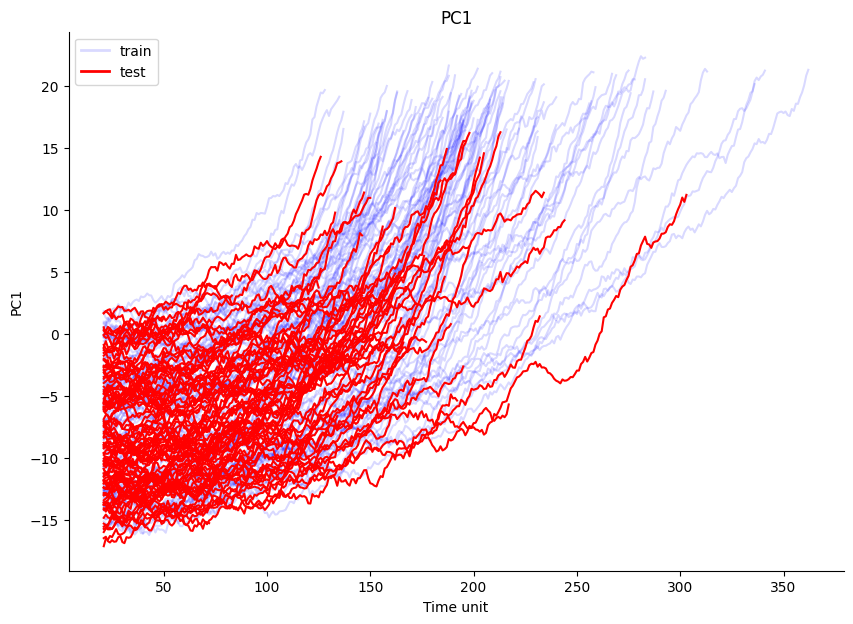

In [33]:
principal_component = 'PC1'

custom_lines = [Line2D([0], [0], color='b', lw=2, alpha = .15),
                Line2D([0], [0], color='r', lw=2)]
plt.rcParams["figure.figsize"] = (10,7)
for i in train_machine_ids:
    train_inverse_indiv = train_inverse.loc[i, ['Time unit', principal_component]]
    train_inverse_indiv[principal_component + '_rolling'] = train_inverse_indiv[principal_component].rolling(21).mean()

    plt.plot(train_inverse_indiv['Time unit'],
             train_inverse_indiv[principal_component + '_rolling'],
             color = 'b',
             alpha = .15,
             label = 'train')

for i in test_machine_ids:
    test_inverse_indiv = test_inverse.loc[i, ['Time unit', principal_component]]
    test_inverse_indiv[principal_component + '_rolling'] = test_inverse_indiv[principal_component].rolling(21).mean()

    plt.plot(test_inverse_indiv['Time unit'],
             test_inverse_indiv[principal_component + '_rolling'],
             color = 'r',
             label = 'test')

plt.legend(custom_lines, ['train', 'test'], loc = 'upper left')
plt.xlabel('Time unit')
plt.ylabel(principal_component)
plt.title(principal_component)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

The above figure shows that the engines all start at a different value and all decay at a different pace. Also, there exists a variance in point of failure on the principal component (y-axis). This is even more when we plot the real decay signal instead of the rolling mean. These are difficulties we will have to overcome when we start predictive modelling. 

Notice, however, that all decay signals do follow a similar trend. The machines all decay at an accelarating pace.

Now we know that the first principal component possesses predicitve power for failure, how can we model this? How can we define a model that fits the data well?

### Data explanation

#### Conclusions
- There are multiple ways to to fit this data to a model.
- The decay signal follows an exponential trend.
- This trend can be modeled by averaging the machine decay signals in the following form: $decay = a e^{b RUL} + c$

### Model development by averaging machine decay singals.
Firstly, we can aggregate all the engines to an average behaving machine. How would the average machine behave towards decay? This is similar to what we did in the first plot of the principal components.

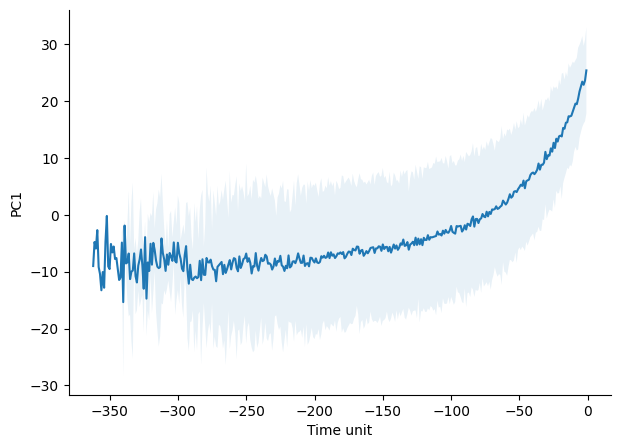

In [34]:
plt.rcParams["figure.figsize"] = (7,5)
pc = train_inverse[['PC1']]
pc = pc.reset_index('Machine id')
pc_agg = pd.DataFrame({'Inverse time unit': list(range(cutoff, 0)),
                        'Average': [pc.loc[i, principal_component].mean() for i in range(cutoff, 0)],
                        'Sd': [pc.loc[i, principal_component].std() for i in range(cutoff, 0)]})
pc_agg['confidence_low'] = pc_agg['Average'] - 1.96 * pc_agg['Sd']
pc_agg['confidence_high'] = pc_agg['Average'] + 1.96 * pc_agg['Sd']

plt.plot(pc_agg['Inverse time unit'], pc_agg['Average'])
plt.fill_between(pc_agg['Inverse time unit'], pc_agg['confidence_low'],
                      pc_agg['confidence_high'], alpha = .1)

train_inverse_agg = train_inverse.groupby(level = 'Inverse time unit')[['PC1']].mean()
x = np.array(train_inverse_agg.index)
y = np.array(train_inverse_agg['PC1'])
plt.xlabel('Time unit')
plt.ylabel(principal_component)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

We can fit a curve to this data. We just need to define how the curve will approximately look like. An exponential function is first what comes to mind, so let's try that. The following is just an example of a simple exponential function, there are several ways to approximate an exponential function.

$d = a e^{b t} + c$

Where $d$ is the decay signal, which is equal to PC1, the first principal component. $t$ is the inverse time unit. The rest of the parameters ($a, b, c$) have to be defined through optimization.

In [35]:
params = optimize.curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, x, y)[0]
params

array([ 3.27735427e+01,  1.77819368e-02, -8.63169617e+00])

Now that we have the rest of our parameters, we can implement those in the function and plot the result.

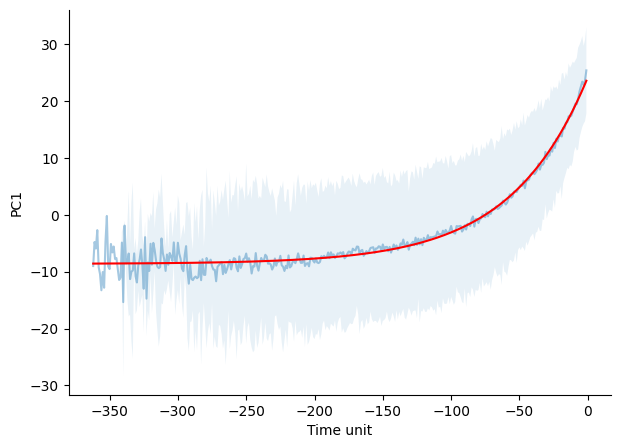

In [36]:
d = params[0] * np.exp(params[1] * x) + params[2]
plt.plot(pc_agg['Inverse time unit'], pc_agg['Average'], alpha = .4)
plt.fill_between(pc_agg['Inverse time unit'], pc_agg['confidence_low'],
                 pc_agg['confidence_high'], alpha = .1)
plt.plot(pc_agg['Inverse time unit'], d, color = 'r')
plt.xlabel('Time unit')
plt.ylabel(principal_component)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

This fits the data really well. However, we don't want to predict the decay signal. We want to predict the Remaining Useful Lifetime (RUL). In other words, we want to predict the time units as a function of the decay signal. To do this, we have to solve the above function for $t$:

$d = a e^{b t} + c$, becomes

$t = \frac{ln{\frac{d - c}{a}}}{b}$

$t$ is still the inverse time unit term for the RUL, so we will have to multiply that by -1. Secondly, we know the values for $a, b, c$, so our final model will be:

$-RUL = \frac{ln{\frac{d + 8.63}{32.8}}}{.0178}$

For the visualization to be clean and pretty, we have to sort the data by $d$. Hence, this is the new value on the x-axis.

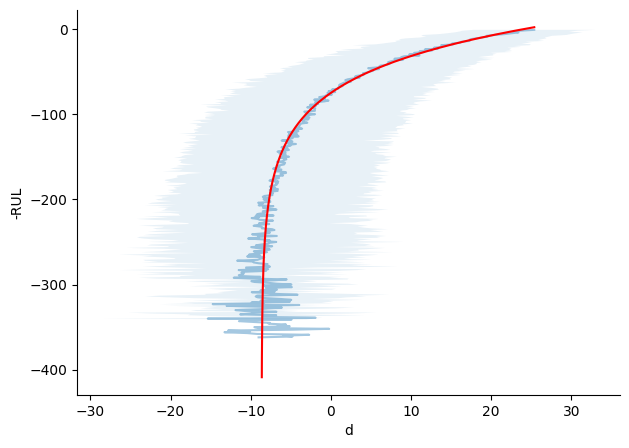

In [37]:
x = np.array(train_inverse_agg['PC1'])
y = np.array(train_inverse_agg.index)
plt.plot(pc_agg['Average'], pc_agg['Inverse time unit'], alpha = .4)
plt.fill_betweenx(pc_agg['Inverse time unit'], pc_agg['confidence_low'],
                  pc_agg['confidence_high'], alpha = .1)
t = np.log((x - params[2]) / params[0]) / params[1]
xy_sorted = pd.DataFrame({'x': x,
                          'rul': t}).sort_values(by = 'x')
x = xy_sorted['x']
t = xy_sorted['rul']
plt.plot(x, t, color = 'r')
plt.ylabel('-RUL')
plt.xlabel('d')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

This is an example of how to design a model that fits the data. However, the plot shows a lot of noise, this is due to the fact that different machines behave differently towards the point of failure.

### Conclusions
- We ended up with just one decay signal (the first principal component of our PCA analysis), which describes the data very well. However, the individual engines behave differently over time and also within every machine there still exists some noise. This makes constructing a good fitting model more complex.
- This decay signal shows a remarkable exponential trend and can be modeled through a simple fitting method.
- This method is a simple solution for this problem, because it averages the decay behaviour of all machines. It fits the data well, but not very well.

### Building a predictive model
Now it's time to build some models.

#### Conclusions
- There are multiple ways to predict engine decay.
- In our first attempt we average the behaviour of all the engines and we use the model to literally predict the RUL, with the decay signal being above a certain threshold. This results in acceptable predictions.
- The seond method uses machine-specific predictions, following approximately the same rules as our first method.
- The last predictive model uses a LGBM model and inherits some of the trend line characteristics from our first method for feature engineering purposes.

### Evaluation
In order to monitor the prediction accuracy of our models we will define a function that evaluates our models, so we can compare them.

In [38]:
def score(target, prediction, print_output = True):
    target = np.array(target)
    prediction = np.array(prediction)
    error = target - prediction
    
    rmse = np.sqrt(np.mean(error ** 2))
    
    if print_output:
        print(f'Root mean squared erorr: {rmse}' )

        # plot
        min_all = min(min(target), min(prediction))
        max_all = max(max(target), max(prediction))
        plt.plot([min_all, max_all], [min_all, max_all])
        plt.scatter(target, prediction)
        plt.xlabel('target')
        plt.ylabel('prediction')
    
    return rmse

### Test evaluation using sample predictions: average RUL for any machine still alive after test run length
In order to get a grasp of what is a minimum performing model, it's usually best practice to develop a baseline model. This is a simple model, and it's used to compare the other models with.

In [39]:
test_base_predict = test.reset_index('Time unit').groupby(level = 'Machine id')['Time unit'].size().to_frame()
test_base_predict = test_base_predict.rename(columns = {'Time unit': 'finished_runs'})
test_base_predict['target'] = target.values.flatten()
test_base_predict

finished_runs  target
Machine id                       
101                    31     112
102                    49      98
103                   126      69
104                   106      82
105                    98      91
...                   ...     ...
196                    97     137
197                   134      82
198                   121      59
199                    97     117
200                   198      20

[100 rows x 2 columns]

Below the code for predicting via the first simple base model. This prediction is based on the average training machine lifetimes, only of the machines that have at least as many RULs as the finished runs of the test machine. As a result, no negative values are predicted.

In [40]:
train_machine_lifetimes = train.reset_index('Time unit').groupby(level = 'Machine id')['Time unit'].size()
test_base_predict['predicted_by_average'] = [train_machine_lifetimes[train_machine_lifetimes > fr].mean() - fr
                                             for fr in test_base_predict['finished_runs']]
test_base_predict

finished_runs  target  predicted_by_average
Machine id                                             
101                    31     112            175.310000
102                    49      98            157.310000
103                   126      69             80.310000
104                   106      82            100.310000
105                    98      91            108.310000
...                   ...     ...                   ...
196                    97     137            109.310000
197                   134      82             73.101010
198                   121      59             85.310000
199                    97     117            109.310000
200                   198      20             41.235294

[100 rows x 3 columns]

Root mean squared erorr: 36.72216273227603


36.72216273227603

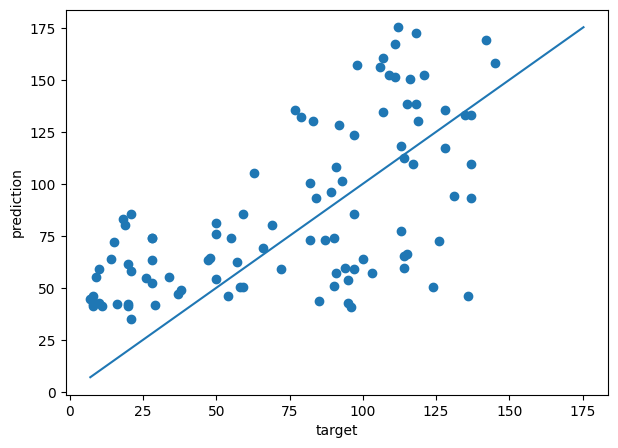

In [41]:
score(test_base_predict['target'], test_base_predict['predicted_by_average'])

### Test evaluation using sample predictions: Weibull distributed RUL ignoring measurements
Below a slightly different example, but with similar result. These predictions are based on the Weibull distribution.

In [42]:
xx = np.linspace(100, 400, 300)
mlt_cdf = [((train_machine_lifetimes < x).sum()) / len(train_machine_lifetimes) for x in xx]
weibull_params = optimize.curve_fit(stats.weibull_min.cdf, xx, mlt_cdf, [3, 120, 80])[0]
weibull_params

array([  1.63237321, 136.18672758,  77.6995994 ])

In [43]:
test_base_predict['predicted_by_weibull'] = [stats.weibull_min.expect(args = (weibull_params[0], ),
                                                                  loc = weibull_params[1],
                                                                  scale = weibull_params[2],
                                                                  lb = fr,
                                                                  conditional = True) - fr
                                             for fr in test_base_predict['finished_runs']]
test_base_predict

finished_runs  target  predicted_by_average  predicted_by_weibull
Machine id                                                                   
101                    31     112            175.310000            174.727632
102                    49      98            157.310000            156.727632
103                   126      69             80.310000             79.727632
104                   106      82            100.310000             99.727632
105                    98      91            108.310000            107.727632
...                   ...     ...                   ...                   ...
196                    97     137            109.310000            108.727632
197                   134      82             73.101010             71.727632
198                   121      59             85.310000             84.727632
199                    97     117            109.310000            108.727632
200                   198      20             41.235294             41.720553

[100 rows x 4 columns]

Root mean squared erorr: 36.90981713028552


36.90981713028552

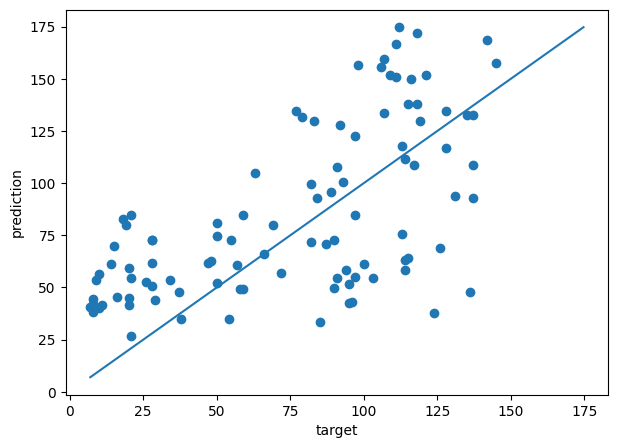

In [44]:
score(test_base_predict['target'], test_base_predict['predicted_by_weibull'])

Now we know how well our baseline models perform, we can start with developing our own model and compare it with these models.

## Predictive model development

### Method 1: Using the average trend line to predict RULs

$-RUL = \frac{ln{\frac{d + 8.63}{32.8}}}{.0178}$

Our final formula is shown above. However, if you look again at the last plot of 'Model development by averaging machine decay singals' you can clearly see that when RUL is below a certain point (approx. -200), the signal behaves mostly like noise. This is because of the uncertainty about when an engine fails. This means that, when an engine still has more than 200 time units left, the model isn't able to accurately predict when an engine fails.

This brings us to the Weibull distribution again. In the previous section (constructing the Weibull base model) we fitted the Weibull distribution with certain parameters to the training data. With these parameters we can calculate the total expected lifetime of an engine. This tells us that when we have no model, and only know the finished runs of an engine, we expect the engine to last for 'expectation - finished runs = rul'. So with zero finished runs, it expects the following RUL.

In [45]:
weibull_expectation = stats.weibull_min.expect(args = (weibull_params[0], ),
                                               loc = weibull_params[1],
                                               scale = weibull_params[2])
weibull_expectation

205.72763166977424

Consequently, we'll never expect that the RUL + finished runs will exceed the expectation value. The expectation value is very similar to the value of where we see only noise in the plot. This is probably not a coincidence. Therefore, the accompanying $d$ (PC1) value can be calculated and can act as a threshold from where we use the model for prediction, instead of only the finished runs.

In [46]:
threshold = params[0] * np.exp(params[1] * - weibull_expectation) + params[2]
threshold

-7.786861376121474

Now we can define a prediction function. We will use this later in a pandas apply function.

In [47]:
def predict_rul(row):
    if row['PC1'] <= threshold:
        y = stats.weibull_min.expect(args = (weibull_params[0], ),
                                     loc = weibull_params[1],
                                     scale = weibull_params[2],
                                     lb = row['finished_runs'],
                                     conditional = True) - row['finished_runs']
    else:
        y = -np.log((row['PC1'] - params[2]) / params[0]) / params[1]
    
    return y

Next, we have to transform the test data in order to fit the model. Notice that we only predict the RUL using the last PC1 value and the number of finished runs.

In [48]:
test_data = test[prediction_columns]
test_data['PC1'] = np.array(pca.transform(test_data).transpose()[0])
test_data = test_data.drop(prediction_columns, axis = 1)
test_data['finished_runs'] = np.array(test_data.reset_index('Time unit')['Time unit'])
test_data

PC1  finished_runs
Machine id Time unit                          
101        1         -11.954407              1
           2         -12.810482              2
           3          -8.395258              3
           4          -5.622992              4
           5          -8.123131              5
...                         ...            ...
200        194        10.430509            194
           195        14.037653            195
           196        -0.247973            196
           197        11.361438            197
           198        19.637008            198

[13096 rows x 2 columns]

The following code isolates only the last PC1 and finished runs values (of the last time points), because we only need that to get a prediction. Also, it gets rid of the time unit index, because for prediction we don't need that anymore.

In [49]:
test_predict = test_data.groupby('Machine id').tail(1).reset_index('Time unit', drop = True)
test_predict['target'] = test_base_predict['target']
test_predict

PC1  finished_runs  target
Machine id                                  
101        -13.307169             31     112
102         -0.593195             49      98
103          8.447869            126      69
104          0.448979            106      82
105          8.743721             98      91
...               ...            ...     ...
196         -9.608959             97     137
197         -1.895040            134      82
198         10.110574            121      59
199        -12.493011             97     117
200         19.637008            198      20

[100 rows x 3 columns]

Now we can predict the RUL.

In [50]:
test_predict['predicted_simple'] = test_predict.apply(predict_rul, axis = 1)
test_predict

PC1  finished_runs  target  predicted_simple
Machine id                                                    
101        -13.307169             31     112        174.727632
102         -0.593195             49      98         79.034076
103          8.447869            126      69         36.651735
104          0.448979            106      82         72.178472
105          8.743721             98      91         35.685942
...               ...            ...     ...               ...
196         -9.608959             97     137        108.727632
197         -1.895040            134      82         88.969939
198         10.110574            121      59         31.427406
199        -12.493011             97     117        108.727632
200         19.637008            198      20          8.315530

[100 rows x 4 columns]

Now we can compare this model with the baseline models, let's see how it performs.

Root mean squared erorr: 31.12333865519396


31.12333865519396

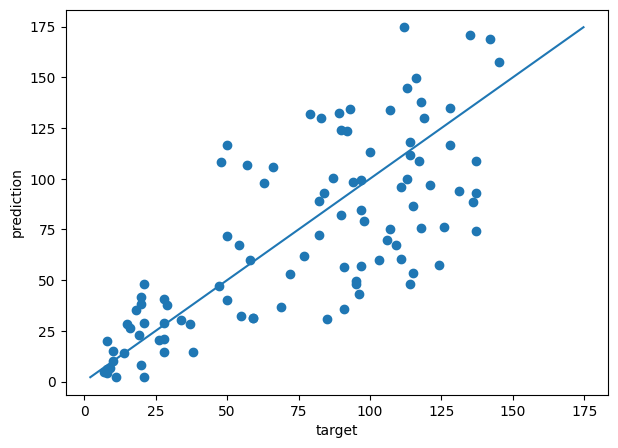

In [51]:
score(test_predict['target'], test_predict['predicted_simple'])

As you can see, it predicts significantly better than the baseline models, but can we do better? Now let's create a predictive model using the machine-specific fit method. It fits the data better, but do we also <u>predict</u> the RUL better when we use this method?

### Method 2: Machine-specific extension for simple model
For explanational purposes we have to cut the training data at random time points, so that we have a mock-test and mock-target set. For replicational purposes, we have to set the seed for these random cutting points. In order to approximate a resemblance of the test data, we make sure that we don't exceed the minimum and maximum boundaries of the test set. We will refer the amount of rows in our mock-test set per engine as Finished Runs (FR) and the values in our mock-target set we will refer as Remaining Useful Lifetime (RUL).

In [52]:
point_of_failure = train_inverse.xs(-1, level = 'Inverse time unit')['PC1'].median()

train_data = train.copy()
train_data['PC1'] = pca.transform(train[prediction_columns]).transpose()[0]
train_data = train_data[prediction_columns + ['PC1']].drop(prediction_columns, axis = 1)

test['PC1'] = pca.transform(test[prediction_columns]).transpose()[0]
test = test[['PC1']]

n = len(train_machine_lifetimes)
test_fr = test.groupby('Machine id').size().to_numpy()
test_rul = target['RUL'].to_numpy()

test_mock_fr = []
for i in train_machine_ids:
    min_cut = max(min(test_fr), train_machine_lifetimes[i] - max(test_rul))
    max_cut = min(max(test_fr), train_machine_lifetimes[i] - min(test_rul))
    np.random.seed(i)
    cutting_point = int(round(np.random.uniform(min_cut, max_cut, size = 1)[0]))
    test_mock_fr.append(cutting_point)

test_mock_fr = np.array(test_mock_fr)

test_mock = {'train': None,
             'target': None}
mock_parts = []
for mid in train_machine_ids:
    mock_part = train_data.loc[mid].reset_index('Time unit').head(test_mock_fr[mid-1])
    mock_part['Machine id'] = mid
    mock_parts.append(mock_part)

test_mock['train'] = pd.concat(mock_parts, ignore_index = True).set_index(['Machine id', 'Time unit'])
test_mock['target'] = train_machine_lifetimes.to_numpy() - test_mock_fr

print('First engine total lifetime in training set: {}'.format(train_data.loc[1].shape[0]))
print('First engine cutting point: {}'.format(test_mock['train'].loc[1].shape[0]))
print('First engine target: {}'.format(test_mock['target'][0]))

test_mock['train'].loc[1]

First engine total lifetime in training set: 192
First engine cutting point: 105
First engine target: 87


PC1
Time unit           
1          -7.800385
2          -4.559961
3          -5.804056
4         -10.186059
5          -6.244623
...              ...
101        -8.130638
102        -5.442042
103        -9.636722
104        -2.479941
105        -6.059216

[105 rows x 1 columns]

In our previous method we used an overall fuction in the form of $d = a e^{b t} + c$. However, it's also possible to fit an exponential function in the following form: $d = e^{a t} + b$, where we only use two parameters. This will save time and it will fit the individual train engines pretty good. From these fits, we will gain different $a$ and $b$ values for every individual machine. We will use the $0.95 \cdot min$ and $1.05 \cdot max$ values of $a$ and $b$ as bounds for the curve fitting of the (mock-)test set.

In [53]:
ab_values = {'Machine id': [],
              'a': [],
              'b': []}
for mid in train_machine_ids:
    x = train_data.loc[mid].index
    y = train_data.loc[mid, 'PC1']
    params = optimize.curve_fit(lambda t, a, b: np.exp(a * t) + b, x, y, p0 = [.0184, -11.4])[0]
    ab_values['Machine id'].append(mid)
    ab_values['a'].append(params[0])
    ab_values['b'].append(params[1])

ab_values = pd.DataFrame(ab_values).set_index('Machine id')
minmax_ab = [[min(ab_values[x]) * .95 for x in ab_values], [max(ab_values[x]) *1.05 for x in ab_values]]
minmax_ab

[[0.009193788863106987, -16.125750421719392],
 [0.02753819821836787, 0.9360794262738178]]

### Curve fitting
We will follow the same method (curve fitting) for the mock-test set as we did for the train set (getting the $a$ and $b$ values). However, the fit will be not as good, because the decay signal doesn't proceed up to the point where it fails. As you can see below, it stops at a certain random time point.

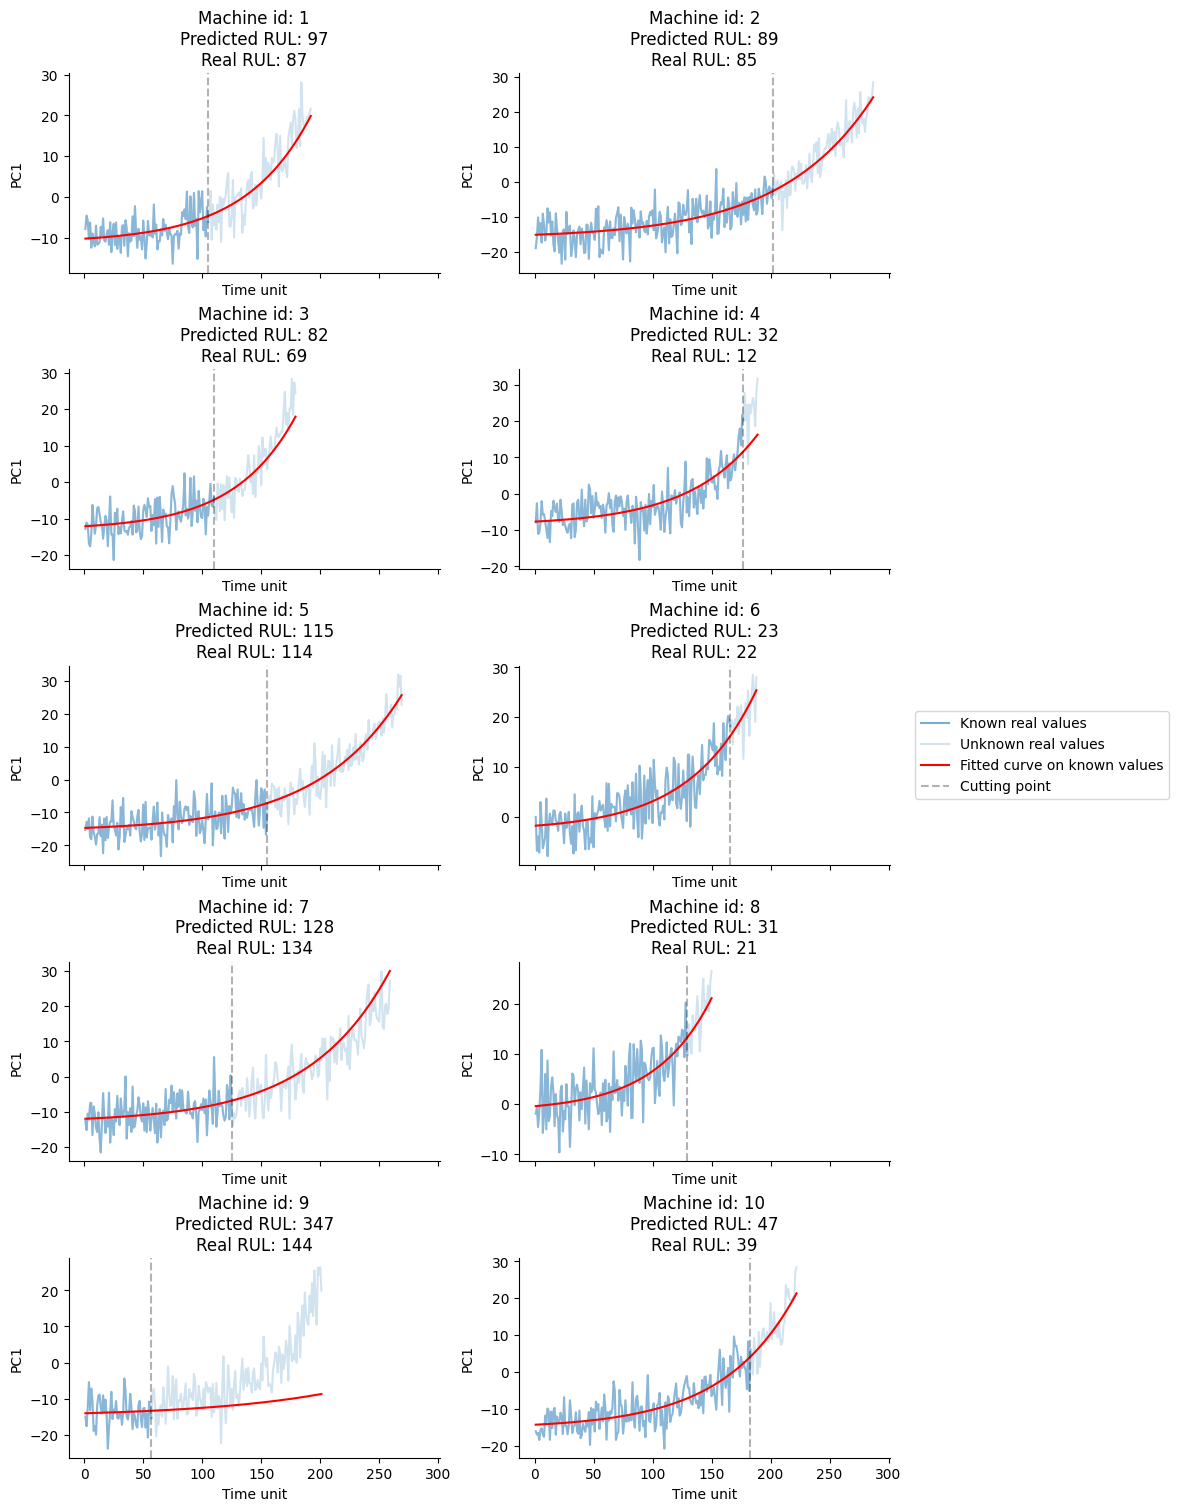

In [54]:
plt_rows = 5
plt_cols = 2
fig, ax = plt.subplots(plt_rows, plt_cols, sharex = True, figsize = (9, plt_rows * 3),
                       constrained_layout = True)
custom_lines = [Line2D([0], [0], alpha = .6),
                Line2D([0], [0], alpha = .2),
                Line2D([0], [0], color = 'r'),
                Line2D([0], [0], color = 'k', alpha = .3, linestyle = 'dashed')]
for r in range(plt_rows):
    for c in range(plt_cols):
        mid = (r * plt_cols + c) + 1
        train_x = train_data.loc[mid].index
        train_y = train_data.loc[mid, 'PC1']
        data = test_mock['train']
        tar = test_mock['target'][mid-1]
        x = data.loc[mid].index
        y = data.loc[mid, 'PC1']
        a_param, b_param = optimize.curve_fit(f = lambda t, a, b: np.exp(a * t) + b,
                                    xdata = x, ydata = y, p0 = [.0184, -11.4], bounds = minmax_ab)[0]

        t = np.exp(a_param * train_x) + b_param
        pred = round((np.log(point_of_failure - b_param) / a_param) - (len(x) - 1))
        ax[r, c].plot(train_x, train_y, alpha = .2)
        ax[r, c].plot(x, y, alpha = .4, color = 'C0')
        ax[r, c].plot(train_x, t, color = 'r')
        ax[r, c].axvline(len(x), color = 'k', alpha = .3, linestyle = 'dashed')
        ax[r, c].set_xlabel('Time unit')
        ax[r, c].set_ylabel('PC1')
        ax[r, c].set_title(f'Machine id: {mid}\nPredicted RUL: {pred}\nReal RUL: {tar}')
        ax[r, c].spines['top'].set_visible(False)
        ax[r, c].spines['right'].set_visible(False)

fig.legend(custom_lines, ['Known real values', 'Unknown real values', 'Fitted curve on known values', 'Cutting point'],
           loc = 'center right', bbox_to_anchor = (1.3, .5))

We imitated the test set with the training set, as if we didn't know the real values from the cutting point onwards. As you can see it fits the data and predicts the RULs pretty well. But check out Machine 9: It has only a few datapoints and the slope for the last known time point (57) is almost flat. For engines with only a few datapoints (and thus an almost flat slope) the uncertainty is very high. Therefore, we must add an $a$ value threshold `a_t` ('t' stands for threshold), in order to pull the $a$ parameter towards a more reasonable value. This threshold has to be optimized. The scale of this pulling is defined by the `root`, which also has to be optimized. Those are our two hyperparameters. Adding the hyperparameters will give us the below function `predict_machine_specific`.

In [55]:
def predict_machine_specific(data, a_t, root):
    predictions = []
    data_machine_ids = data.reset_index('Machine id')['Machine id'].unique()
    for mid in data_machine_ids:
        x = data.loc[mid].index
        y = data.loc[mid, 'PC1']
        a_param, b_param = optimize.curve_fit(f = lambda t, a, b: np.exp(a * t) + b,
                                    xdata = x, ydata = y, p0 = [.0184, -11.4], bounds = minmax_ab)[0]
        starting_point = np.mean(y[1:19])
        sp_dif = starting_point - b_param
        if sp_dif <= 0:
            b_param = starting_point - .1

        slope0 = 1 / (a_param * (starting_point - b_param))
        slope1 = 1 / (a_param * (len(y) - b_param))

        param_weight = 1 - (slope1 / slope0**root)
        if a_param < a_t:
            a_param = np.average([a_t, a_param], weights = [1 - param_weight, param_weight])

        if (len(x) - 1) > (np.log(point_of_failure - b_param) / a_param):
            prediction = 0
        else:
            prediction = int(round((np.log(point_of_failure - b_param) / a_param) - (len(x) - 1)))
        predictions.append(prediction)
    
    return predictions

The `a_t` parameter serves as a threshold for the $a$ parameter (from the `curve_fit` optimizer). If the $a$ parameter is lower than this threshold (then the pace of decay is pretty low), then the value of the $a$ parameter is pulled towards this threshold. The strength of this pull is dependent of the steepness of the curve at the cutting point. Check out the figure above, for Machine 9, the pulling towards `a_t` is strong, because the curve is almost flat at the cutting point (57). $slope_0$ is the mean slope of the first 19 datapoints. $slope_1$ is the slope at the cutting point and will be compared to $slope_0$. These are derivatives (hence, slope) of our original function $t = \frac{ln(d - b)}{a}$. The lower $1 - \frac{slope_1}{slope_0}$, the lower the strength of the $a$ parameter is and the more it'll be pulled towards the `a_t` value. The `root` value is a balancing parameter; because we don't know on beforehand if the pull-factor is ok, we have check this by tuning this parameter as well. The final $a$ parameter is then averaged by the original $a$ parameter and the  `a_t` value, both weighted by the $slope_0, slope_1$ ratio.

As you can see we use `optimize.curve_fit` again with our boundaries. In very few cases, this procedure ends up with the $b$ parameter being lower than the mean of our first 19 `PC1` datapoints. We need these 19 first datapoints to calculate the slope of the first uncertain part of the decay signal, and it's important that this slope is positive. This is important because we want to compare our slopes, so we can distribute the weights in our `np.average` function and these weights have to be positive to work properly. Also, for very few engines the prediction will be negative (it must have been failed already/it already had to be maintained), for these cases the prediction will be zero (`prediction = 0`).

Now we can check if this algorithm works for randomly picked (but reasonable) `a_t` and `root` values, by plotting Machine 9 again. We just add the part of the code where we use the slopes of the first 19 time points and the cutting point to determine how much we pull the $a$ parameter towards a more common value.

Text(0.5, 1.0, 'Machine id: 9\nPredicted RUL: 164\nReal RUL: 144')

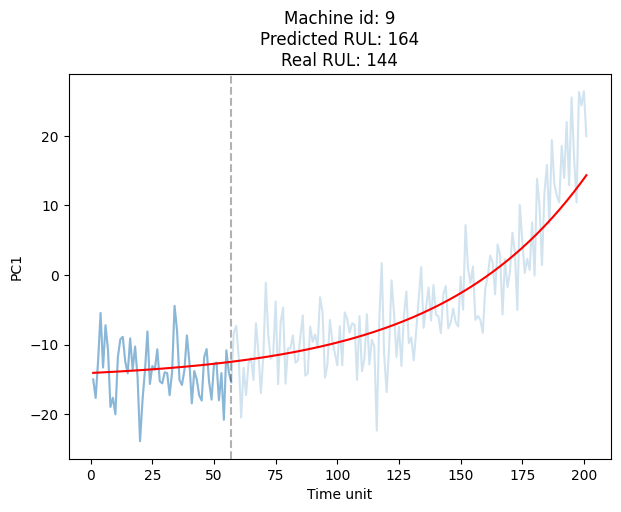

In [56]:
a_t = .02
root = .2
mid = 9

train_x = train_data.loc[mid].index
train_y = train_data.loc[mid, 'PC1']
data = test_mock['train']
tar = test_mock['target'][mid-1]
x = data.loc[mid].index
y = data.loc[mid, 'PC1']
a_param, b_param = optimize.curve_fit(f = lambda t, a, b: np.exp(a * t) + b,
                                      xdata = x, ydata = y, p0 = [.0184, -11.4], bounds = minmax_ab)[0]

starting_point = np.mean(y[1:19])
sp_dif = starting_point - b_param
if sp_dif <= 0:
    b_param = starting_point - .1

slope0 = 1 / (a_param * (starting_point - b_param))
slope1 = 1 / (a_param * (len(y) - b_param))

param_weight = 1 - (slope1 / slope0**root)
if a_param < a_t:
    a_param = np.average([a_t, a_param], weights = [1 - param_weight, param_weight])

t = np.exp(a_param * train_x) + b_param
pred = round((np.log(point_of_failure - b_param) / a_param) - (len(x) - 1))
plt.plot(train_x, train_y, alpha = .2)
plt.plot(x, y, alpha = .4, color = 'C0')
plt.plot(train_x, t, color = 'r')
plt.axvline(len(x), color = 'k', alpha = .3, linestyle = 'dashed')
plt.xlabel('Time unit')
plt.ylabel('PC1')
plt.title(f'Machine id: {mid}\nPredicted RUL: {pred}\nReal RUL: {tar}')

As you can see, the curve fits the data much better. However, Machine 9 is not the only engine with only few datapoints needing good fit. Now we need optimized `a_t` and `root` values for all engines.

### Hyperparameter tuning
The following is used for optimizing the hyperparameters `a_t` and `root`. This could be done with the scikit-learn GridSearchCV method, optuna, or scipy.optimize.minimize, but it's fun to do this ourselves. We collect the predictions for all combinations of the parameter `search_space`, transform it into a dataframe and pick the parameter values with the lowest score.

In [61]:
a_ts = np.linspace(.014, .024, 6)
roots = np.linspace(.05, .35, 7)
search_space = list(product(list(a_ts), list(roots)))

ms_hp = {'a_t': None,
         'root': None}

counter = 0
d = {'a_t': [],
     'root': [],
     'score': []}

for a_t, root in search_space:
    counter += 1
    print(f'{int(round(((counter)/(len(a_ts) * len(roots)))*100))}%', end = '\r')

    predictions = predict_machine_specific(test, a_t, root)
    d['score'].append(score(test_rul, predictions, print_output = False))
    d['a_t'].append(a_t)
    d['root'].append(root)

dfd = pd.DataFrame(d)
best_idx = dfd['score'].idxmin()
ms_hp['a_t'], ms_hp['root'] = dfd.loc[best_idx, ['a_t', 'root']].to_list()

ms_hp

{'a_t': 0.02, 'root': 0.15}

Root mean squared erorr: 22.315465489207256


22.315465489207256

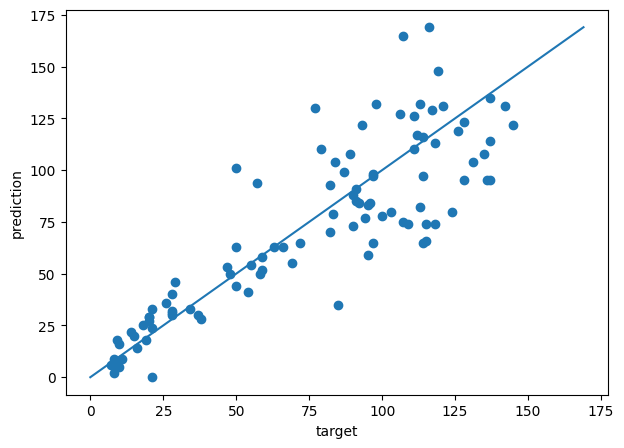

In [62]:
predictions = predict_machine_specific(test, ms_hp['a_t'], ms_hp['root'])

score(test_rul, predictions)

Way better to fit machine-specific trendlines!

### Method 3: Feature engineering and black-box modeling


The last approach involves a black-box model, just to show you that it's possible. To do this, it's very important that you really understand the data, because it's impossible to make a good prediction with a quick '.fit-.predict' procedure. Now, for the training data we know the RUL and we have the PC1 decay signal. Also, we have the normal time unit. Check out the dataset below. With this, we can create meaningful variables for which we will fit a Light Gradient Boosting Regressor (LGBR) (or any regressor, we just picked a non-linear one we like).

In [71]:
train = train_data.copy()
train['rul'] = np.array(train.reset_index('Time unit').groupby(level = 'Machine id')['Time unit'].transform(lambda x:
                                                                                                      (x - np.max(x)) - 1) * -1)
train['TU'] = np.array(train.reset_index('Time unit')['Time unit'])
train

PC1  rul   TU
Machine id Time unit                     
1          1          -7.800385  192    1
           2          -4.559961  191    2
           3          -5.804056  190    3
           4         -10.186059  189    4
           5          -6.244623  188    5
...                         ...  ...  ...
100        196        21.270477    5  196
           197        28.536723    4  197
           198        23.208698    3  198
           199        22.884492    2  199
           200        25.424049    1  200

[20631 rows x 3 columns]

### Feature engineering
#### Part 1: Smoothing parameter

Earlier we used a rolling mean of the decay signals. We need it again for our new features. However, it's important to notice that we can choose the number of rows it averages. We will call this our `smoothing` parameter, because the rolling mean actually smoothens the decay signal. With a higher number, the smoother the signal will be. Also, we showed that the decay signal resembles an exponential curve. With a smooth exponential curve it's logical that when the difference in decay signal is higher between two time points, the faster it decays, hence sooner it will fail. Now we only have to decide the delta (difference) of two time points from which we will calculate the difference in decay signal. Besides these delta columns, there is another one; we also want to know what the difference is between the smoothened `PC1` starting point and the rest of the smoothened `PC1` values of the decay signal (greater difference; closer to failure). Below the function, and below that, an example.

In [72]:
def add_delta_cols(df, smoothing):
    df['PC1_rolling'] = np.array(df.groupby('Machine id')[['PC1']].rolling(smoothing).mean())
    delta_cols = []
    delta_col = 2
    ii = 0
    while delta_col >= 2:
        delta_col = round((31-smoothing) / 2**ii)
        delta_cols.append(delta_col)
        ii += 1
    delta_cols = np.array(delta_cols)
    delta_cols = delta_cols[delta_cols >= 2]
    for i in delta_cols:
        df[f'delta_{i}'] = df['PC1_rolling'] - df['PC1_rolling'].shift(i)

    df['delta_begin'] = df.groupby('Machine id')['PC1_rolling'].transform(lambda x: x - np.array(x)[smoothing-1])
    
    return df

The resulting dataframe for the first engine with `smoothing` `5` looks like this:

In [73]:
add_delta_cols(train.copy(), 5).loc[1].head(35)

PC1  rul  TU  PC1_rolling  delta_26  delta_13   delta_6  \
Time unit                                                                  
1          -7.800385  192   1          NaN       NaN       NaN       NaN   
2          -4.559961  191   2          NaN       NaN       NaN       NaN   
3          -5.804056  190   3          NaN       NaN       NaN       NaN   
4         -10.186059  189   4          NaN       NaN       NaN       NaN   
5          -6.244623  188   5    -6.919017       NaN       NaN       NaN   
6         -12.420162  187   6    -7.842972       NaN       NaN       NaN   
7          -8.949088  186   7    -8.720797       NaN       NaN       NaN   
8         -10.909345  185   8    -9.741855       NaN       NaN       NaN   
9         -12.090110  184   9   -10.122666       NaN       NaN       NaN   
10         -7.015760  183  10   -10.276893       NaN       NaN       NaN   
11        -11.675229  182  11   -10.127906       NaN       NaN -3.208890   
12        -11.417072  181  12   -10.621503       NaN       NaN -2.778531   
13        -11.098287  180  13   -10.659291       NaN       NaN -1.938494   
14         -7.311498  179  14    -9.703569       NaN       NaN  0.038286   
15         -9.481528  178  15   -10.196723       NaN       NaN -0.074057   
16         -5.261748  177  16    -8.914026       NaN       NaN  1.362867   
17        -10.646406  176  17    -8.759893       NaN       NaN  1.368013   
18        -10.945469  175  18    -8.729330       NaN -1.810313  1.892173   
19         -9.180815  174  19    -9.103193       NaN -1.260221  1.556098   
20         -8.091008  173  20    -8.825089       NaN -0.104292  0.878480   
21        -11.719416  172  21   -10.116623       NaN -0.374768  0.080100   
22         -6.170256  171  22    -9.221393       NaN  0.901273 -0.307367   
23        -13.512642  170  23    -9.734828       NaN  0.542065 -0.974934   
24         -8.722004  169  24    -9.643065       NaN  0.484841 -0.913736   
25         -6.551129  168  25    -9.335089       NaN  1.286414 -0.231896   
26        -11.774006  167  26    -9.346007       NaN  1.313284 -0.520918   
27         -6.226650  166  27    -9.357286       NaN  0.346283  0.759337   
28        -12.722891  165  28    -9.199336       NaN  0.997387  0.022057   
29         -9.795490  164  29    -9.414033       NaN -0.500007  0.320794   
30        -10.028796  163  30   -10.109567       NaN -1.349674 -0.466501   
31        -13.685844  162  31   -10.491934 -3.572918 -1.762605 -1.156845   
32         -7.221542  161  32   -10.690913 -2.847941 -1.587720 -1.344905   
33         -6.875611  160  33    -9.521457 -0.800659 -0.696367 -0.164170   
34        -11.931668  159  34    -9.948692 -0.206837  0.167931 -0.749356   
35         -5.690966  158  35    -9.081126  1.041540  0.140267  0.332907   

            delta_3   delta_2  delta_begin  
Time unit                                   
1               NaN       NaN          NaN  
2               NaN       NaN          NaN  
3               NaN       NaN          NaN  
4               NaN       NaN          NaN  
5               NaN       NaN     0.000000  
6               NaN       NaN    -0.923955  
7               NaN -1.801781    -1.801781  
8         -2.822839 -1.898883    -2.822839  
9         -2.279694 -1.401868    -3.203649  
10        -1.556096 -0.535038    -3.357876  
11        -0.386051 -0.005241    -3.208890  
12        -0.498837 -0.344610    -3.702486  
13        -0.382398 -0.531385    -3.740275  
14         0.424337  0.917934    -2.784552  
15         0.424780  0.462569    -3.277706  
16         1.745265  0.789543    -1.995010  
17         0.943676  1.436829    -1.840876  
18         1.467393  0.184697    -1.810313  
19        -0.189167 -0.343300    -2.184177  
20        -0.065196 -0.095760    -1.906073  
21        -1.387293 -1.013430    -3.197606  
22        -0.118200 -0.396304    -2.302376  
23        -0.909738  0.381795    -2.815811  
24         0.473558 -0.421672    -2.724049  
25        -0.113696  0.399738    -

`PC1_rolling` is the rolling mean of the past 5 time points. `delta_26` is the `PC1_rolling` difference of time unit $t$ and time unit $t+26$. `delta_begin` is the `PC1_rolling` difference between the first known `PC1_rolling` value (here -6.919) and the `PC1_rolling` values.

The resulting dataframe for the first engine with `smoothing` `24` looks like this:

In [74]:
add_delta_cols(train.copy(), 24).loc[1].head(35)

PC1  rul  TU  PC1_rolling   delta_7   delta_4   delta_2  \
Time unit                                                                  
1          -7.800385  192   1          NaN       NaN       NaN       NaN   
2          -4.559961  191   2          NaN       NaN       NaN       NaN   
3          -5.804056  190   3          NaN       NaN       NaN       NaN   
4         -10.186059  189   4          NaN       NaN       NaN       NaN   
5          -6.244623  188   5          NaN       NaN       NaN       NaN   
6         -12.420162  187   6          NaN       NaN       NaN       NaN   
7          -8.949088  186   7          NaN       NaN       NaN       NaN   
8         -10.909345  185   8          NaN       NaN       NaN       NaN   
9         -12.090110  184   9          NaN       NaN       NaN       NaN   
10         -7.015760  183  10          NaN       NaN       NaN       NaN   
11        -11.675229  182  11          NaN       NaN       NaN       NaN   
12        -11.417072  181  12          NaN       NaN       NaN       NaN   
13        -11.098287  180  13          NaN       NaN       NaN       NaN   
14         -7.311498  179  14          NaN       NaN       NaN       NaN   
15         -9.481528  178  15          NaN       NaN       NaN       NaN   
16         -5.261748  177  16          NaN       NaN       NaN       NaN   
17        -10.646406  176  17          NaN       NaN       NaN       NaN   
18        -10.945469  175  18          NaN       NaN       NaN       NaN   
19         -9.180815  174  19          NaN       NaN       NaN       NaN   
20         -8.091008  173  20          NaN       NaN       NaN       NaN   
21        -11.719416  172  21          NaN       NaN       NaN       NaN   
22         -6.170256  171  22          NaN       NaN       NaN       NaN   
23        -13.512642  170  23          NaN       NaN       NaN       NaN   
24         -8.722004  169  24    -9.217205       NaN       NaN       NaN   
25         -6.551129  168  25    -9.165153       NaN       NaN       NaN   
26        -11.774006  167  26    -9.465738       NaN       NaN -0.248533   
27         -6.226650  166  27    -9.483346       NaN       NaN -0.318193   
28        -12.722891  165  28    -9.589048       NaN -0.371842 -0.123309   
29         -9.795490  164  29    -9.737000       NaN -0.571847 -0.253654   
30        -10.028796  163  30    -9.637360       NaN -0.171622 -0.048313   
31        -13.685844  162  31    -9.834725 -0.617520 -0.351379 -0.097725   
32         -7.221542  161  32    -9.681066 -0.515914 -0.092019 -0.043706   
33         -6.875611  160  33    -9.463796  0.001942  0.273205  0.370929   
34        -11.931668  159  34    -9.668625 -0.185279 -0.031265  0.012441   
35         -5.690966  158  35    -9.419281  0.169767  0.415444  0.044515   

           delta_begin  
Time unit               
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  
6                  NaN  
7                  NaN  
8                  NaN  
9                  NaN  
10                 NaN  
11                 NaN  
12                 NaN  
13                 NaN  
14                 NaN  
15                 NaN  
16                 NaN  
17                 NaN  
18                 NaN  
19                 NaN  
20                 NaN  
21                 NaN  
22                 NaN  
23                 NaN  
24            0.000000  
25            0.052052  
26           -0.248533  
27           -0.266141  
28           -0.371842  
29           -0.519795  
30           -0.420155  
31           -0.617520  
32           -0.463861  
33           -0.246590  
34           -0.451420  
35           -0.202076

Because in the test set, the minimum amount of known signal values for an engine is 32, with this setup, we could never get a rolling mean of more than 31. And because we need at least a couple of `delta_`columns, the maximum value for the `smoothing` parameter is around 25. Finally, notice the difference in number of columns. We decided to create `delta_`columns with an (approximately) exponential increasing value (with `smoothing` parameter value `5`: 2, 3, 6, 13, 26).

With <u>only</u> these newly created `delta_`columns (including `delta_begin`) and the `TU` we predict the RUL, using a LGBR. Now we fit the LGBR on the following dataset, with the `delta_`columns and `TU` column as predictors and the `rul` column as target. Notice that we use <u>all</u> rows to train this model.

In [75]:
smoothing = 5

train_tmp = add_delta_cols(train.copy(), smoothing)
train_tmp

PC1  rul   TU  PC1_rolling  delta_26   delta_13  \
Machine id Time unit                                                          
1          1          -7.800385  192    1          NaN       NaN        NaN   
           2          -4.559961  191    2          NaN       NaN        NaN   
           3          -5.804056  190    3          NaN       NaN        NaN   
           4         -10.186059  189    4          NaN       NaN        NaN   
           5          -6.244623  188    5    -6.919017       NaN        NaN   
...                         ...  ...  ...          ...       ...        ...   
100        196        21.270477    5  196    20.573645  6.388685   6.730683   
           197        28.536723    4  197    23.282405  9.224703  10.005451   
           198        23.208698    3  198    23.456463  7.529876   9.031687   
           199        22.884492    2  199    24.129453  8.799540   8.340531   
           200        25.424049    1  200    24.264888  8.129582   8.557985   

                       delta_6   delta_3   delta_2  delta_begin  
Machine id Time unit                                             
1          1               NaN       NaN       NaN          NaN  
           2               NaN       NaN       NaN          NaN  
           3               NaN       NaN       NaN          NaN  
           4               NaN       NaN       NaN          NaN  
           5               NaN       NaN       NaN     0.000000  
...                        ...       ...       ...          ...  
100        196        3.760756  0.895466  0.489281    28.671107  
           197        4.333008  3.198041  1.668393    31.379867  
           198        4.407298  1.842451  2.882818    31.553925  
           199        4.451275  3.555808  0.847049    32.226916  
           200        4.180524  0.982483  0.808425    32.362350  

[20631 rows x 10 columns]

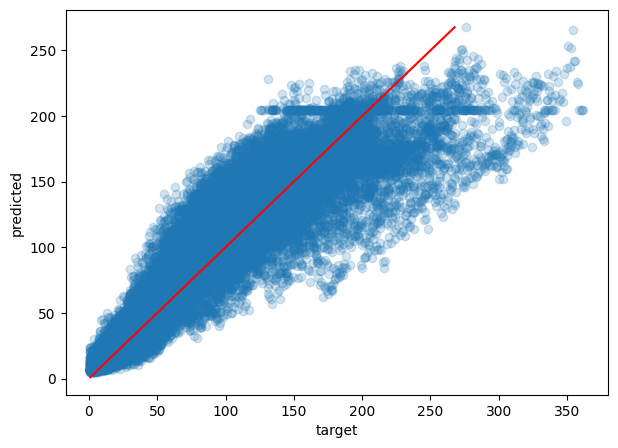

In [76]:
def fit_overall_regressor(data, add_plot = True):
    X = data[[col for col in data if col.startswith('delta')] + ['TU']]
    y = data['rul']
    reg = LGBMRegressor()
    reg.fit(X, y)
    y_pred = reg.predict(X)
    
    if add_plot:
        min_all = min(min(y), min(y_pred))
        max_all = min(max(y), max(y_pred))
        plt.plot([min_all, max_all], [min_all, max_all], color = 'r')
        plt.scatter(np.array(y), np.array(y_pred), alpha = .2)
        plt.xlabel('target')
        plt.ylabel('predicted')

        plt.show()
    
    return reg

reg = fit_overall_regressor(train_tmp)

This plot looks promising, we're on the right track. But there is one more hyperparameter we need to optimize in order to get a good fitting model.

#### Part 2: Percentage-of-latest-time-points parameter
In theory, for every engine, the last part (latest time points) of the data is more predictive for the RUL than the first part of the data. We've seen that at the beginning of the engine lifetime there is a lot of noise, and not much predictive information. Consequently, we have to decide which percentage of the data for every individual machine we keep for fitting the LGBR. If we exclude too much data, the model will underfit. But if we include too much data it will suffer from too many uninformative data (overfit).

In [77]:
def keep_last_rows(df, p):
    df_parts = []
    ids = df.reset_index(level = 'Machine id')['Machine id'].unique()
    for mid in ids:
        n_rows = len(df.loc[mid])
        keep_rows = int(round(n_rows * p))
        df_part = df.loc[mid].reset_index('Time unit').tail(keep_rows)
        df_part['Machine id'] = mid
        df_parts.append(df_part)

    df = pd.concat(df_parts, ignore_index = True).set_index(['Machine id', 'Time unit'])
    
    return df

The resulting dataframe for the first engine with `smoothing` `5` and `p_rows` `0.8` looks like this:

In [78]:
p_rows = .8

train_tmp = add_delta_cols(train.copy(), smoothing)
keep_last_rows(train_tmp, p_rows).loc[1]

PC1  rul   TU  PC1_rolling   delta_26  delta_13   delta_6  \
Time unit                                                                    
39        -10.928126  154   39    -9.510380   1.148911 -0.164373  0.011077   
40        -10.568572  153   40   -10.485901  -0.782332 -1.128615 -0.537209   
41         -4.738799  152   41    -9.926659   0.270064 -0.727323 -0.845533   
42         -9.611199  151   42    -8.941785  -0.027759  0.472248 -1.090826   
43         -2.237928  150   43    -7.616925   1.142968  2.492642  1.696840   
...              ...  ...  ...          ...        ...       ...       ...   
188        18.274386    5  188    20.272431  11.292796  8.207528  2.797926   
189        19.695913    4  189    18.592246   7.364118  5.194848  2.845056   
190        19.685789    3  190    18.507863   6.961988  2.265718  0.938153   
191        20.677465    2  191    19.089551   8.712206  1.507516 -0.100060   
192        21.611538    1  192    19.989018   8.455907  1.891752 -0.011421   

            delta_3   delta_2  delta_begin  
Time unit                                   
39        -1.659421 -0.196615    -2.591363  
40        -1.172136 -0.774813    -3.566884  
41        -0.215570 -0.416279    -3.007642  
42         0.568595  1.544116    -2.022768  
43         2.868976  2.309734    -0.697908  
...             ...       ...          ...  
188        1.082821  0.271992    27.191448  
189       -1.408193 -0.530305    25.511263  
190       -0.614688 -1.764569    25.426879  
191       -1.182880  0.497305    26.008568  
192        1.396772  1.481155    26.908035  

[154 rows x 10 columns]

As you can see, the last 80% of all datapoints for this engine are kept; $\frac{192 - 39}{192} = 0.8$. Now we can fit our black-box model again.

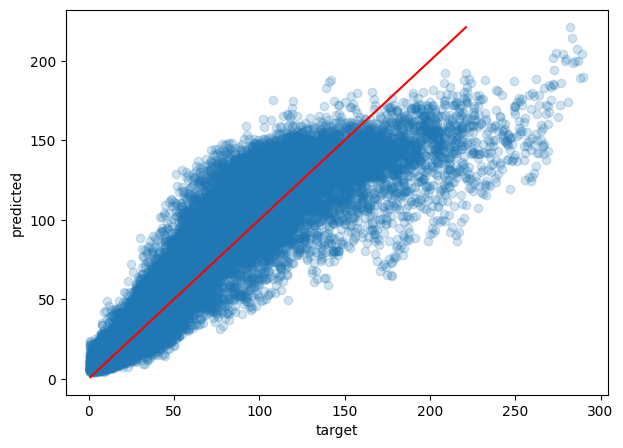

In [79]:
train_p_rows = keep_last_rows(train_tmp, p_rows)
reg = fit_overall_regressor(train_p_rows)

Let's fit this model to our test set. Before we can, we first have to transform our test data so that the LGBR can predict its RULs, because the LGBR is fitted on the `delta_`columns and the test set doesn't have these yet. Also, we have to cut our test set, so it will end up with a percentage of the last time points. We also add the predictions to all the rows of the test set.

In [80]:
def add_predictions(data):
    X = data[[col for col in data if col.startswith('delta')] + ['TU']]
    data['predict'] = reg.predict(X)
    
    return data

def test_data_preparation(smoothing, p_rows):
    dst = test.copy()
    dst['TU'] = np.array(dst.reset_index('Time unit')['Time unit'])

    dst = add_delta_cols(dst, smoothing)
    dst = keep_last_rows(dst, p_rows)
    dst = add_predictions(dst)
    
    dst = dst.reset_index('Time unit')
    dst['ITU'] = dst.groupby('Machine id')['TU'].transform(lambda x: np.max(x) - x)
    dst = dst.set_index('ITU', append = True).drop('Time unit', axis = 1)
    
    return dst

In [81]:
test_predict = test_data_preparation(smoothing, p_rows)
test_predict

PC1   TU  PC1_rolling   delta_26  delta_13   delta_6  \
Machine id ITU                                                               
101        24   -7.395589    7    -9.448010        NaN       NaN       NaN   
           23  -11.738667    8   -10.116692        NaN       NaN       NaN   
           22    3.831966    9    -8.225700        NaN       NaN       NaN   
           21  -11.795741   10    -8.960222        NaN       NaN       NaN   
           20   -9.460127   11    -7.311632        NaN       NaN  2.069622   
...                   ...  ...          ...        ...       ...       ...   
200        4    10.430509  194     9.828717   9.824065  7.700938  3.676138   
           3    14.037653  195     9.652128   9.707079  6.494145  3.611650   
           2    -0.247973  196     8.824050   8.911705  5.633498  0.787828   
           1    11.361438  197     8.637767   9.130360  4.164023  1.221103   
           0    19.637008  198    11.043727  12.697040  7.010199  3.023880   

                 delta_3   delta_2  delta_begin     predict  
Machine id ITU                                               
101        24        NaN -0.066756    -0.066756  105.582277  
           23  -0.735438  0.414297    -0.735438  106.499970  
           22   2.305288  1.222310     1.155554  111.431570  
           21   0.487788  1.156470     0.421032  106.446022  
           20   2.805060  0.914069     2.069622  116.631412  
...                  ...       ...          ...         ...  
200        4    2.412053  1.808870    19.401500   27.170146  
           3    1.632281  0.233768    19.224910   25.366906  
           2   -0.594310 -1.004666    18.396833   25.711213  
           1   -1.190950 -1.014361    18.210549   25.859648  
           0    1.391599  2.219677    20.616510   20.049706  

[10476 rows x 10 columns]

We base our predictions <u>only</u> on the last time unit (with `ITU` value `0`), the following is a quick way to do that. Then we can test our predictions.

Root mean squared erorr: 23.08428433199214


23.08428433199214

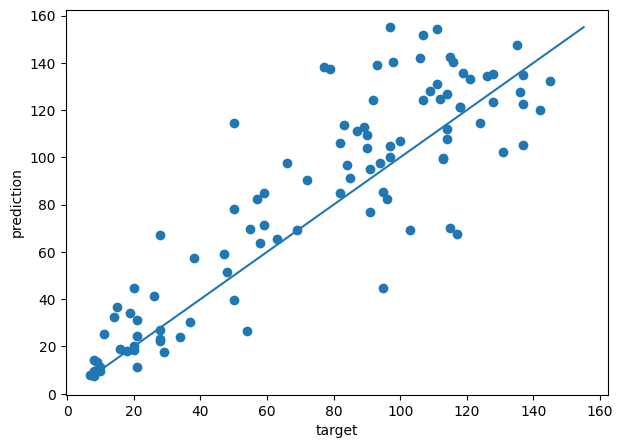

In [82]:
predictions = test_predict.xs(0, level = 'ITU')['predict'].to_numpy()

score(test_rul, predictions)

Not bad for the first try. Let's tune our hyperparameters. These hyperparameters are an element of our feature engineering process, so we would have to take all the steps again during this tuning process.

### Hyperparameter tuning
We follow the same logic as with our first alternative solution for the hyperparameter tuning. We will end up with the optimized values for our `smoothing` and `p_rows` hyperparameters.

In [84]:
smoothings = range(5, 26, 2)
p_rows = np.linspace(.55, .88, 4)

search_space = list(product(list(smoothings), list(p_rows)))
bb_hp = {'sm': None,
         'pr': None}

count = 0
dd = {'smoothing': [],
      'p_rows': [],
      'score': []}
for sm, pr in search_space:
    count += 1
    print(f'{round(count/len(search_space)*100)}%', end = '\r')

    train_predict = add_delta_cols(train.copy(), sm)
    train_predict = keep_last_rows(train_predict, pr)
    X = train_predict[[col for col in train_predict if col.startswith('delta')] + ['TU']]
    y = train_predict['rul']
    reg = LGBMRegressor()
    reg.fit(X, y)
    
    test_predict = test_data_preparation(sm, pr)
    predictions = test_predict.xs(0, level = 'ITU')['predict'].to_numpy()
    sc = score(test_rul, predictions, print_output = False)

    dd['smoothing'].append(sm)
    dd['p_rows'].append(pr)
    dd['score'].append(sc)

dfdd = pd.DataFrame(dd)
idx_best = dfdd['score'].idxmin()
bb_hp['sm'] = dfdd.loc[idx_best, 'smoothing']
bb_hp['pr'] = dfdd.loc[idx_best, 'p_rows']

bb_hp

{'sm': 15, 'pr': 0.66}

Now we can insert these best parameters and check how good the predictions are. Remember that we insert these hyperparameters during the feature engineering process, so we have to take all the steps again from the beginning.

Root mean squared erorr: 19.068084908935703


19.068084908935703

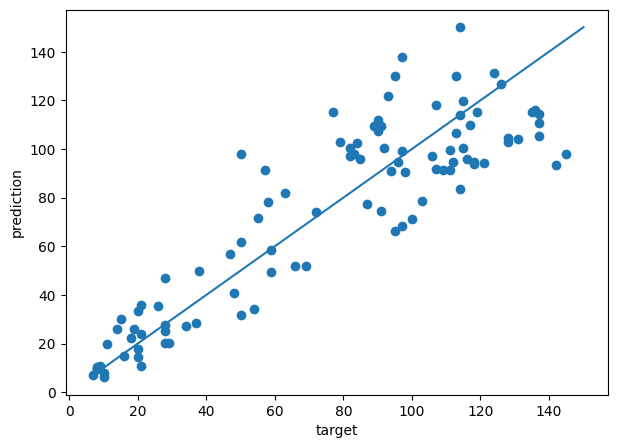

In [85]:
train_predict = add_delta_cols(train.copy(), bb_hp['sm'])
train_predict = keep_last_rows(train_predict, bb_hp['pr'])
X = train_predict[[col for col in train_predict if col.startswith('delta')] + ['TU']]
y = train_predict['rul']
reg = LGBMRegressor()
reg.fit(X, y)
test_predict = test_data_preparation(bb_hp['sm'], bb_hp['pr'])
predictions = test_predict.xs(0, level = 'ITU')['predict'].to_numpy()

score(test_rul, predictions)

Pretty good!